<img src="https://upload.wikimedia.org/wikipedia/fr/b/bf/Universit%C3%A9_Laval_logo_et_texte.svg" width=200 align="right"><br>
<b> Optoélectronique GEL-4203 / GEL-7041 </b><br>
<b> Département de Génie Électrique et de Génie Informatique </b><br>
<b> Automne 2025 </b><br>
<b> Université Laval </b><br>


<h1><center> Travail 3 </center></h1>

##### Remise 
- Votre notebook (.ipynb) ou un document au format PDF contenant vos démarches, réponses clairement identifiées et vos scripts (Python, Matlab ou autre
- Sur la boîte de dépôt dans monportail
- Au plus tard le "à déterminer"
##### Équipe
- Ce travail est *individuel*

##### Pondération : 
<!-- - GEL-4203 : Ce travail vaut pour *5%* de la note finale
- GEL-7041 : Ce travail vaut pour *5%* de la note finale -->

## Identification
- **Nom** : Éloi Blouin
- **Matricule** : 536 999 917

## Consignes pour répondre aux questions
- Utilisez des cellules de Markdown pour fournir des explications écrites et des équations mathématiques.
    - Vous pouvez faire une équation $\LaTeX$ sur une ligne: $\sum_{n = 0}^\infty x^n$.
    - Vous pouvez faire une équation $\LaTeX$ centrée: $$\sum_{n = 0}^\infty x^n.$$
    - Vous pouvez imbriquer des listes:
        - Niveau 2
            - Niveau 3
- Utilisez des cellules de code pour effectuer vos calculs numériques. Prenez soin de bien commenter votre code, de choisir des noms de variables explicites et de "print()" vos réponses.
- N'hésitez-pas à encapsuler vos calculs répétés dans des fonctions. À plusieurs endroits, il vous sera suggéré de créer des fonctions spécifiques. Ce n'est pas obligatoire mais fortement conseillé.
- Seules les librairies suivantes sont permises. Parmi celles-ci figure les fonctions de résolution de guide d'onde 1D.

In [150]:
""" 
Librairies permises
N'utilisez que les librairies Python suivantes
"""
print("Importing allowed libraries...")
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cte
import scipy.integrate as integrate
import scipy.interpolate as interp
import types
from GEL4203_utils import guide_1d_analytique

Importing allowed libraries...


In [151]:
def reset_globals_variables():
    """ Supprime toutes les variables globales sauf les fonctions et les modules importés """
    
    # Obtenir la liste des noms dans l'espace global
    current_globals = list(globals().keys())

    for name in current_globals:
        # 1. Skip names that start with an underscore (Python's convention for "internal" names)
        if name.startswith('_'):
            continue

        # 2. Get the object associated with the name
        obj = globals()[name]

        # 3. Skip imported packages (modules), functions, and classes
        if isinstance(obj, types.ModuleType) or isinstance(obj, types.FunctionType) or isinstance(obj, type):
            continue

        # 4. If it's a regular variable, delete it
        del globals()[name]


### Question 1 - Conception d'une cavité Fabry-Péro (10%)
Pour ce problème, vous pouvez ignorer les effets de dispersion. Considérez un guide d'onde dont l'indice effectif est 2.45. À partir de ce guide d'onde, vous concevez une cavité Fabry-Pérot. Les pertes dans le guide d'onde sont $\alpha = 10$ dB/cm. Coefficient de réflexion des facettes est r = $r_1$ = $r_2$ avec $  r^2 + t^2=1 $.  La longueur de la cavité est L.

##### 1.A (2.5 points) Démontrez que les longueurs d'ondes résonantes obéissent la relation:
$$ \lambda_{res} = \frac{2 n_{eff} L}{m}. $$

L'onde électromagnétique oscille selon 
$$
\vec{E} = E_0 e^{i(kz + ωt)}
$$
Pour arrivé en résonance, elle doit arrivé en phase avec elle même lors d'une oscillation dans la cavité de longueur $z=2L$ alors elle doit parcourir une phase de $δ =m2π$ ou $m \in \mathbb{N}$. Ainsi,
$$
k⋅z = 2πm\\
k⋅2L = \cfrac{2πn}{λ}⋅2L = 2πm\\
 λ  = \cfrac{2Ln}{m}
$$
À noter que si l'onde se déplace dans une guide d'onde avec plusieurs indice de réfraction, on doit prendre l'indice effective du mode. Ainsi
$$
λ_{res} = \cfrac{2n_{eff}L}{m} \quad\quad \text{où } m \in \mathbb{N}
$$

In [152]:
n_eff_num1 = 2.45
α_dB_num1 = 10  # en dB/cm

##### 1.B (2.5 points) Vous devez aligner un laser émettant à 1300 nm directement sur la résonance $m=100$. Quelle doit être la longueur de la cavité $L$?

In [153]:
def calculate_length_cavity(λ,m, n_eff):
    """ Calcule la longueur de cavité pour une résonance donnée

    Paramètres:
        λ : longueur d'onde en m
        m : ordre de la résonance (entier)
        n_eff : indice effectif du mode dans la cavité

    Retourne:
        L : longueur de la cavité en m
    """
    L = m * λ / (2 * n_eff)
    return L

In [154]:
λ_1_num1 = 1300E-9  # en m
m_1_num1 = 100

L_num1 = calculate_length_cavity(λ_1_num1, m_1_num1, n_eff_num1)
print(f"La longueur de la cavité est de {L_num1*1e6:.3f} µm")


La longueur de la cavité est de 26.531 µm


##### 1.C (2.5 points) Quel est l'interval spectral libre (FSR) en nanomètres et en fréquences à 1300 nm?

L'équation pour le FSR et le facteur de qualité est 
$$
FSR = \frac{λ^2}{2n_{eff}L}\\
Q = \frac{π\sqrt{R}}{1-r} = \frac{FSR}{FWHM}
$$

In [155]:
def calculate_FSR(λ, L, n_eff):
    """ Calcule le Free Spectral Range (FSR) d'une cavité résonante

    Paramètres:
        λ : longueur d'onde en m
        L : longueur de la cavité en m
        n_eff : indice effectif du mode dans la cavité

    Retourne:
        FSR : Free Spectral Range en m
    """
    FSR = λ**2 / (2 * n_eff * L)
    return FSR

In [156]:
FSR_num1 = calculate_FSR(λ_1_num1, L_num1, n_eff_num1)
print(f"Le FSR est de {FSR_num1*1e9:.3f} nm")

Le FSR est de 13.000 nm


Le facteur de qualité (Q) d'une cavité Fabry-Pérot donne une indication sur la capacité de la cavité résonante à selectionner une fréquence. Le facteur de qualité peut être exprimé par:
$$ Q = \frac{2 \pi  f n_g L}{c A} =  \frac{f}{\Delta f_{1/2}} $$

où A = $\alpha L -\ln(\sqrt{r_1^2 r_2^2})$ est la fraction de puissance perdue par aller-retour dans le résonateur, $\alpha$ est le coefficient de perte du guide d'onde [1/m], $n_g$ est l'indice de groupe (ici $n_g$ = neff car on ne considère pas la dispersion), $f$ est la fréquence centrale, $\Delta f_{1/2}$ est la largeur des résonances en fréquence et L est la longueur de la cavité. 

##### 1.D (2.5 points) Quelle doit être la valeur de $r$ pour optimiser le facteur Q?


Intuitivement plus les factelle de la cavité seront réfléchissante, plus le réseau sera sélectif et aura un facteur de qualité élevé
$$ 
Q = \frac{2 \pi  n_{eff} L}{λ(αL - \ln(r^2))} = \frac{2 \pi  n_{eff}}{λ(α - \frac{\ln(r^2)}{L})} 
$$

In [157]:
def calculate_Q(λ, α, L, r_1, r_2, n_eff):
    f = cte.c / λ
    α_lin = (α / 4.343) * 100  # Convertir dB/cm en 1/m

    Q = (2 * np.pi * n_eff) / (λ * (α_lin - (np.log(np.sqrt(r_1**2 *r_2**2)) / L)))

    return Q

Le facteur de qualité Q pour r_1 = r_2 = 1.00 est de 51427.15


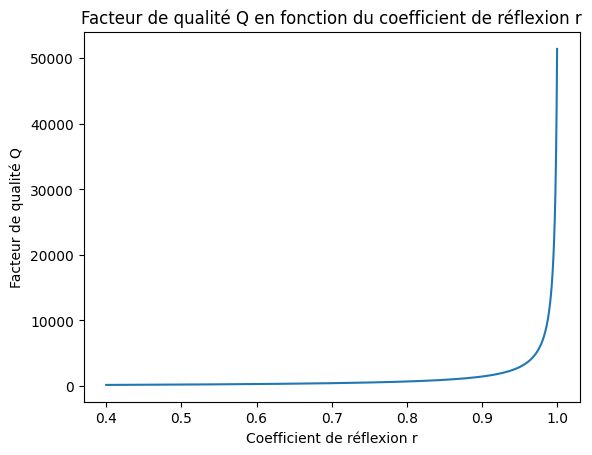

In [158]:
r_num1 = np.linspace(0.4, 1, 10000)
Q_num1 = calculate_Q(λ_1_num1, α_dB_num1, L_num1, r_num1, r_num1, n_eff_num1)
print(f"Le facteur de qualité Q pour r_1 = r_2 = {r_num1[-1]:.2f} est de {Q_num1[-1]:.2f}")

plt.plot(r_num1, Q_num1)
plt.xlabel("Coefficient de réflexion r")
plt.ylabel("Facteur de qualité Q")
plt.title("Facteur de qualité Q en fonction du coefficient de réflexion r")
plt.show()

Ici le facteur de qualité est limité par la perte de propagation de la cavité, par exemple pour $α = 50 \ [dB/cm]$ on obtient des valeurs différente.

In [159]:
α_2_num1 = 50  # en dB/cm
Q_2_num1 = calculate_Q(λ_1_num1, α_2_num1, L_num1, r_num1, r_num1, n_eff_num1)
print(f"Le facteur de qualité Q pour r_1 = r_2 = {r_num1[-1]:.2f} et α = {α_2_num1} dB/cm est de {Q_2_num1[-1]:.2f}")


Le facteur de qualité Q pour r_1 = r_2 = 1.00 et α = 50 dB/cm est de 10285.43


##### 1.E (2.5 points) Tracez la transmittance en dB de la cavité FP. Choisissez une plage de longueur d'onde autour de 1300 nm afin qu'on puisse observer 3 résonances. (supposer que r = 0.99 et que L est la valeur trouvée en B).

Nous devons à chaque longueur d'onde calculer la transmittance de la cavité, c'est à dire la fraction de puissance provenant d'un millieu $1$ qui sera transmit au millieu $3$ passant par la cavité le millieu $2$.

On prend la fonction de transfert de transfert d'une cavité fabry-pérot qui dicte l'intensité du champ électrique incidente et transmise.

$$
\frac{E_t}{E_{in}} = \cfrac{t_1t_2e^{-iβL}}{1-r_1r_2e^{-i2βL}}
$$

Je supose que nous somme à incidence normal alors
$$
β = kcos(θ) = k_0 \cos(0) = \frac{2πn}{λ}\\
$$

Comme nous avons aussi une atténuation dans le milieux, il faut prendre en compte la constante de propagation complexe qui transforme la fonction de transfert du FP.
$$ γ = β+ i α/2 $$
$$  \frac{E_t}{E_{in}} = \cfrac{t_1t_2e^{-iβL}e^{-αL/2}}{1-r_1r_2e^{-i2βL}e^{-αL/2}}    $$


Et le coefficient de réflection et transmission aux interfaces sont 
$$ R_{int}+T_{int}=1 \quad\bigg|\quad R_{int} = r^2 \quad\bigg|\quad T_{int} = t^2\\ $$
$$ r_1^2 + t_1^2 = 1 $$
$$ t_1 = \sqrt{1-r_1^2} $$

Ensuite, pour trouvé la transmitance, on doit mettre au carré la norme du ratio des amplitudes du champ électrique transmis et incident.
$$ T = \frac{\text{Intensité}_{t}}{\text{Intensité}_{in}} = \left|\frac{E_t}{E_{in}}\right|^2  = \left|\cfrac{t_1t_2e^{-iβL}e^{-αL/2}}{1-r_1r_2e^{-i2βL}e^{-αL/2}}\right|^2  $$

In [160]:
def calculate_γ(λ, n_eff, α_dB, θ):
    """ Calcule la constante de propagation complexe γ
    Prend la longueur d'onde λ, l'indice effectif n_eff, la perte α en dB/cm et l'angle θ en radians

    returns:
        γ : constante de propagation complexe
    """
    α_lin = (α_dB / 4.343) * 100  # Convertir dB/cm en 1/m

    # Attention α est une atténuation, donc on ajoute un terme imaginaire positif pour qu'il y ait une décroissance
    k = 2 * np.pi * n_eff / λ

    γ = k * np.cos(θ) - 1j * α_lin/2
    return γ


def calculate_FP_transfert_function(γ, L, r_1, r_2, t_1, t_2):
    """ Calcule la fonction de transfert d'une cavité de Fabry-Perot

    Paramètres:
        γ : constante de propagation complexe
        L : longueur de la cavité en m
        r_1, r_2 : coefficients de réflexion des miroirs

    Retourne:
        H : fonction de transfert complexe
    """
    
    H = (t_1 * t_2 * np.exp(-1j * γ * L)) / (1 - r_1 * r_2 * np.exp(-1j * 2 * γ * L))
    return H

def calculate_transmission(H=None, γ=None, L=None, r_1=None, r_2=None, t_1=None, t_2=None):
    """ Calcule la transmission d'une cavité de Fabry-Perot

    Paramètres:
        H (optional): La fonction de transfert complexe pré-calculée.
        γ, L, r_1, r_2, t_1, t_2 : arguments requis si H n'est pas fourni.

    Retourne:
        T : transmission (réelle)
    """
    
    # Check if H is provided
    if H is None:
        # If H is NOT provided, all other arguments must be present to calculate it.
        # Check for missing required arguments
        if None in (γ.all(), L, r_1, r_2, t_1, t_2):
            raise ValueError(
                "If 'H' is not provided, all arguments (γ, L, r_1, r_2, t_1, t_2) must be supplied."
            )
            
        # Calculate H using the required arguments
        H = calculate_FP_transfert_function(γ, L, r_1, r_2, t_1, t_2)
        
    # Proceed with the main calculation
    T = np.abs(H)**2
    return T

def lin_to_dB(value):
    """ Convertit une valeur linéaire en décibels (dB) """
    return 10 * np.log10(value)

def dB_to_lin(value_dB):
    """ Convertit une valeur en décibels (dB) en valeur linéaire """
    return 10 ** (value_dB / 10)

t_num1 = 0.141 | r_num1 = 0.990
L_num1 = 2.653e-05 m | n_eff_num1 = 2.450 | α_dB_num1 = 10 dB/cm


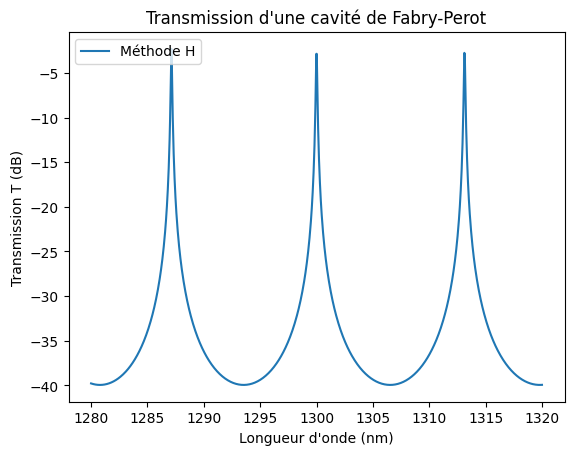

In [161]:
λ_list_num1 = np.linspace(1280e-9, 1320e-9, 1000)
r_num1 = 0.99
t_num1 = np.sqrt(1-r_num1**2)


print(f"t_num1 = {t_num1:.3f} | r_num1 = {r_num1:.3f}")
print(f"L_num1 = {L_num1:.3e} m | n_eff_num1 = {n_eff_num1:.3f} | α_dB_num1 = {α_dB_num1} dB/cm")

# Calcul de γ pour chaque λ
γ_num1 = calculate_γ(λ_list_num1, n_eff_num1, α_dB_num1, 0)
# Calcul de la fonction de transfert H
H_num1 = calculate_FP_transfert_function(γ_num1, L_num1, r_num1, r_num1, t_num1, t_num1)
# Calcul de la transmission T
T_num1 = calculate_transmission(H=H_num1)


plt.plot(λ_list_num1*1e9, lin_to_dB(T_num1), label="Méthode H")
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Transmission T (dB)")
plt.title("Transmission d'une cavité de Fabry-Perot")
plt.legend()
plt.show()




On oberse bien plusieurs pics au longueur d'onde de résonance de la cavité FB. Regardons l'influence du coefficient de réflexion de la cavité


In [162]:
def calculate_transmission_FP(λ, L, n_eff, α_dB, r_1, r_2):
    """ Calcule la transmission d'une cavité de Fabry-Perot

    Paramètres:
        λ : longueur d'onde en m
        L : longueur de la cavité en m
        n_eff : indice effectif du mode dans la cavité
        α_dB : perte en dB/cm
        r_1, r_2 : coefficients de réflexion des miroirs

    Retourne:
        T : transmission (réelle)
    """
    t_1 = np.sqrt(1 - r_1**2)
    t_2 = np.sqrt(1 - r_2**2)

    γ = calculate_γ(λ, n_eff, α_dB, 0)
    T = calculate_transmission(γ=γ, L=L, r_1=r_1, r_2=r_2, t_1=t_1, t_2=t_2)

    return T

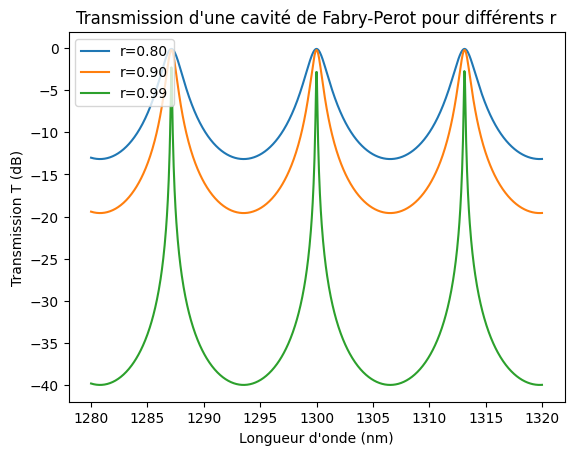

In [163]:
r_list_num1 = [0.8, 0.9, 0.99]
for r in r_list_num1:
    T_num1 = calculate_transmission_FP(λ_list_num1, L_num1, n_eff_num1, α_dB_num1, r, r)
    plt.plot(λ_list_num1*1e9, lin_to_dB(T_num1), label=f"r={r:.2f}")
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Transmission T (dB)")
plt.title("Transmission d'une cavité de Fabry-Perot pour différents r")
plt.legend()
plt.show()

On remarque que oui la finesse augmente avec le coefficient de réflexion mais l'atténuation selon la distance diminue aussi l'amplitude. On se retouve ainsi avec un compromis à faire entre FWHM et amplitud/perte.

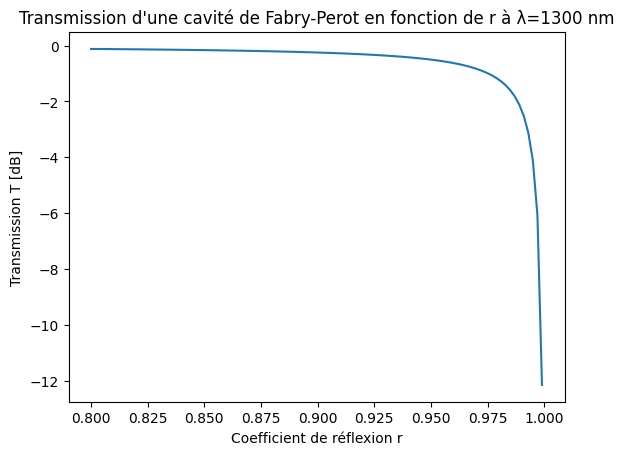

In [164]:
r_list_num1 = np.linspace(0.8, 0.999, 100)

T_max_at_r = []
for i in range(len(r_list_num1)):
    r = r_list_num1[i]
    T_num1 = calculate_transmission_FP(λ_1_num1, L_num1, n_eff_num1, α_dB_num1, r, r)
    T_max_at_r.append(T_num1)

plt.plot(r_list_num1, lin_to_dB(T_max_at_r))
plt.xlabel("Coefficient de réflexion r")
plt.ylabel("Transmission T [dB]")
plt.title("Transmission d'une cavité de Fabry-Perot en fonction de r à λ=1300 nm")
plt.show()

### Question 2 - Laser multimode (20%)

In [165]:
reset_globals_variables()
# Clean up global variables before next question


Considérez un laser multimode basé sur une cavité Fabry-Perot ayant les propriétés suivantes:

| Paramètres du laser | Symbole | Valeur | Unités |
| --- | :----: | :---: | :---: |
| Longueur de la cavité | $L$ | 100 | $\mu m$ |
| Facteur de confinement | $\Gamma$ | 0.1 | - |
| Indice de groupe | $n_g$ | 4.5 | - |
| Coefficient de réflexion des miroirs | $r_{1,2}$ | 0.8, 0.99 | - |
| Coefficient de pertes | $\alpha_i$ | 500 | $m^{-1}$ |
| Longueur d'onde centrale du gain | $\lambda_0$ | 0.95 | $\mu m$|
| Coefficient de gain nominal | $g_0$ | 2000 | cm $^{-1}$ |
| Largeur à mi-hauteur du gain | $\Delta \lambda$ | 20 | nm |
| Courant à la transparence | $I_{tr}$ | 1 | mA |

Utilisez une expression simplifiée de la dépendance spectrale du gain:

$$ g(I, \lambda) = \frac{g_0}{1 + \big(\frac{2(\lambda - \lambda_0)}{\Delta \lambda}\big)^2} \ln \frac{I}{I_{tr}} $$

Cette expression traite uniquement les valeurs positives de $g$. Assumez que l'indice de groupe, le facteur de confinement et le temps de vie des photons sont constants (ne dépendent pas de la longueur d'onde). Vous pouvez aussi ignorer la dispersion.


In [166]:
L = 100e-6  # en m
Γ = 0.1
n_g = 4.5
r_1 = 0.8
r_2 = 0.99
α = 500 # 1/m
λ_0 = 0.95e-6 
g_0_cm = 2000  # 1/cm
g_0 = g_0_cm * 100  # Convertir en 1/m
Δλ = 20e-9  # en m
I_tr = 10e-3  # en A

##### 2.A (5%)  Combien de modes longitudinaux de la cavité laser sont supportés dans la bande passante à 3dB (mi-hauteur) du gain?

Nous avons une cavité de longueur $L$, on peut alors trouver tout les modes qui sont permis et regardé le gain laser à chaque longueur d'onde et filtrer filtrer seulement ceux qui sont au dessus de $50\%$ du maximum de gain. 

On sait déjà que la largeur à mi-hauteur du gain est $Δλ = 20 \ \rm{nm}$ ainsi on peut seulement trouvé les longueurs d'onde qui sont entre 
$$λ =\begin{cases} 			λ_0-Δλ/2 = 940 \ \rm{nm}\\            λ_0+Δλ/2 = 960 \ \rm{nm}	 \end{cases} $$

In [167]:
def calculate_gain(λ, I, g_0, λ_0, Δλ, I_tr):
    """ Calcule le gain optique g en fonction de la longueur d'onde λ et du courant d'injection I
        g : gain optique en 1/m
    """
    g = (g_0 / (1 + ((2 * (λ - λ_0)) / Δλ)**2)) * np.log(I / I_tr)
    return g


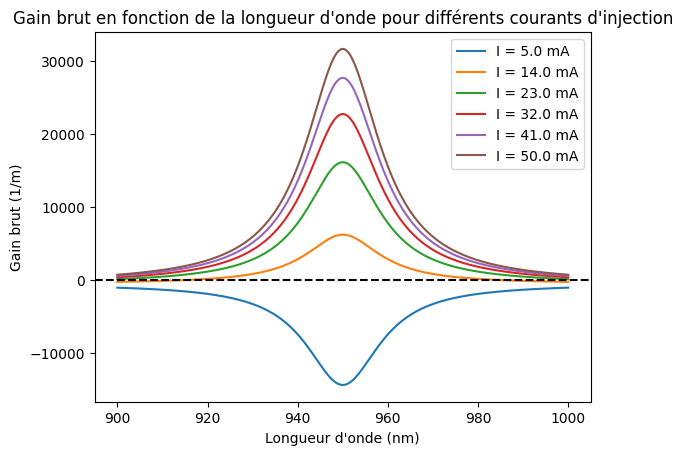

In [168]:
I_lis = np.linspace(5e-3, 50e-3, 6)
λ_array = np.linspace(900e-9, 1000e-9, 1000) 

for I in I_lis:
    g = calculate_gain(λ_array, I, g_0, λ_0, Δλ, I_tr)
    net_gain = Γ * g - α
    plt.plot(λ_array*1e9, net_gain, label=f"I = {I*1e3:.1f} mA")

plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Gain brut (1/m)")
plt.title("Gain brut en fonction de la longueur d'onde pour différents courants d'injection")
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()


Les longueurs d'onde permise sont
$$ \lambda_{res} = \frac{2 n_{eff} L}{m}. $$

In [169]:
def calculate_m_central(λ_0, n_g, L):
    """ Calcule l'ordre de résonance central m_c pour une cavité de longueur L à la longueur d'onde λ_0
    """
    m_c = round((2 * n_g * L) / λ_0)
    return m_c

In [170]:
m = np.linspace(1, 1000, 1000, dtype=int)
λ_res = (2 * n_g * L) / m
nombre = 10

m_central = calculate_m_central(λ_0, n_g, L)

λ_central = (2 * n_g * L) / m_central
print(f"Mode d'ordre central m_central = {m_central} avec une longueur d'onde λ_central = {λ_central*1e9:.1f} nm")

λ_autour = λ_res[m_central - nombre:m_central + nombre + 1]  # Sélectionner les modes autour du mode central
print(λ_autour)
print(f"Longueurs d'onde des modes résonants autour de λ_0 = {λ_0*1e9:.1f} nm :")
for i in λ_autour:
    print(f" - {i*1e9:.1f} nm")

Mode d'ordre central m_central = 947 avec une longueur d'onde λ_central = 950.4 nm
[9.59488273e-07 9.58466454e-07 9.57446809e-07 9.56429330e-07
 9.55414013e-07 9.54400848e-07 9.53389831e-07 9.52380952e-07
 9.51374207e-07 9.50369588e-07 9.49367089e-07 9.48366702e-07
 9.47368421e-07 9.46372240e-07 9.45378151e-07 9.44386149e-07
 9.43396226e-07 9.42408377e-07 9.41422594e-07 9.40438871e-07
 9.39457203e-07]
Longueurs d'onde des modes résonants autour de λ_0 = 950.0 nm :
 - 959.5 nm
 - 958.5 nm
 - 957.4 nm
 - 956.4 nm
 - 955.4 nm
 - 954.4 nm
 - 953.4 nm
 - 952.4 nm
 - 951.4 nm
 - 950.4 nm
 - 949.4 nm
 - 948.4 nm
 - 947.4 nm
 - 946.4 nm
 - 945.4 nm
 - 944.4 nm
 - 943.4 nm
 - 942.4 nm
 - 941.4 nm
 - 940.4 nm
 - 939.5 nm


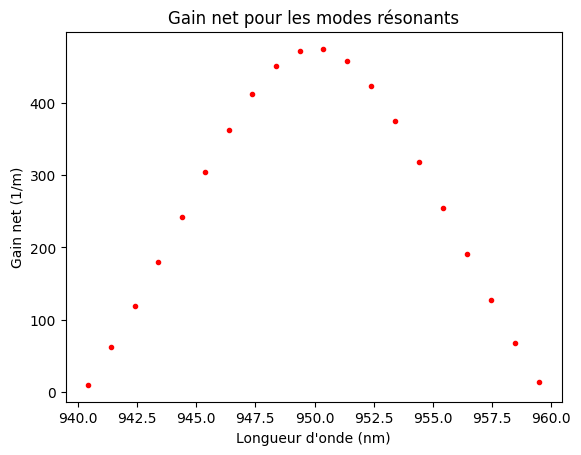

Longueurs d'onde des modes résonants à l'intérieur de la bande passante à -3dB du gain pour 10.500 mA :
λ = 959.49 nm, Gain = 13.51 1/m
λ = 958.47 nm, Gain = 68.38 1/m
λ = 957.45 nm, Gain = 127.71 1/m
λ = 956.43 nm, Gain = 190.41 1/m
λ = 955.41 nm, Gain = 254.61 1/m
λ = 954.40 nm, Gain = 317.48 1/m
λ = 953.39 nm, Gain = 375.23 1/m
λ = 952.38 nm, Gain = 423.45 1/m
λ = 951.37 nm, Gain = 457.72 1/m
λ = 950.37 nm, Gain = 474.47 1/m
λ = 949.37 nm, Gain = 471.91 1/m
λ = 948.37 nm, Gain = 450.45 1/m
λ = 947.37 nm, Gain = 412.60 1/m
λ = 946.37 nm, Gain = 362.32 1/m
λ = 945.38 nm, Gain = 304.05 1/m
λ = 944.39 nm, Gain = 241.97 1/m
λ = 943.40 nm, Gain = 179.48 1/m
λ = 942.41 nm, Gain = 119.04 1/m
λ = 941.42 nm, Gain = 62.19 1/m
λ = 940.44 nm, Gain = 9.78 1/m


In [171]:
λ_inside_3dB = []
gain_inside_3dB = []
I_test = 10.5e-3  # en A Juste pour tracer le gain aux modes résonants

for λ in λ_res:
    if λ > (λ_0 - Δλ/2) and λ < (λ_0 + Δλ/2):
        g = calculate_gain(λ, I_test, g_0, λ_0, Δλ, I_tr)
        net_gain = Γ * g - α
        plt.plot(λ*1e9, net_gain, 'r.')
        λ_inside_3dB.append(λ)
        gain_inside_3dB.append(net_gain)


plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Gain net (1/m)")
plt.title("Gain net pour les modes résonants")
plt.show()

print(f"Longueurs d'onde des modes résonants à l'intérieur de la bande passante à -3dB du gain pour {I_test*1000:.3f} mA :")
for i in range(len(λ_inside_3dB)):
    λ = λ_inside_3dB[i]
    gain = gain_inside_3dB[i]
    print(f"λ = {λ*1e9:.2f} nm, Gain = {gain:.2f} 1/m")


##### 2.B (5%) Tracer le gain $g(I,\lambda)$ pour $I = [10, 15, 20, 25]$ mA ainsi que le gain seuil du laser $g_{th}$. Qu'en déduisez-vous?

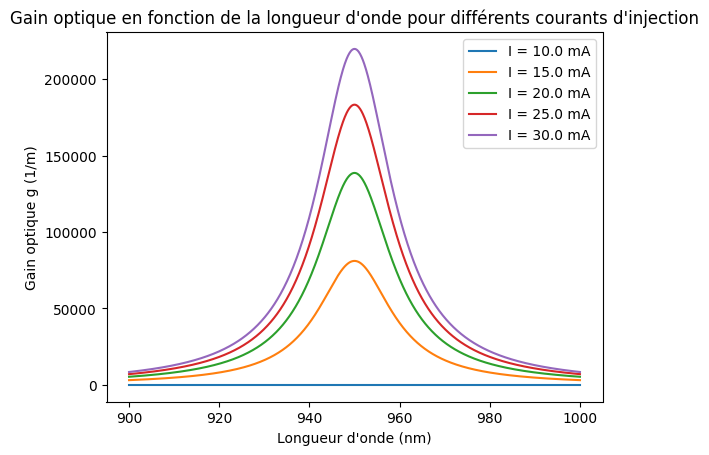

In [172]:
I_list = [10, 15, 20, 25, 30] 
I_list = [I*1e-3 for I in I_list]


gain_brute = {}
for i in range(len(I_list)):
    I = I_list[i]
    gain = calculate_gain(λ_array, I, g_0, λ_0, Δλ, I_tr)
    gain_brute[I] = gain
    plt.plot(λ_array*1e9, gain, label=f"I = {I*1e3:.1f} mA")

plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Gain optique g (1/m)")
plt.title("Gain optique en fonction de la longueur d'onde pour différents courants d'injection")
plt.legend()
plt.show()

Pour calculer le gain seui, il reste à enlever la partie d'atténuation $α$.
Nous savons que le gain seuil arrive à partir du moment où le gain et les pertes sont égal.
$$g_{th}Γ =  α\\ g_{th} = \frac{α}{Γ} = \frac{500}{0.1} =  5000 \ [\rm{1/m}]  $$


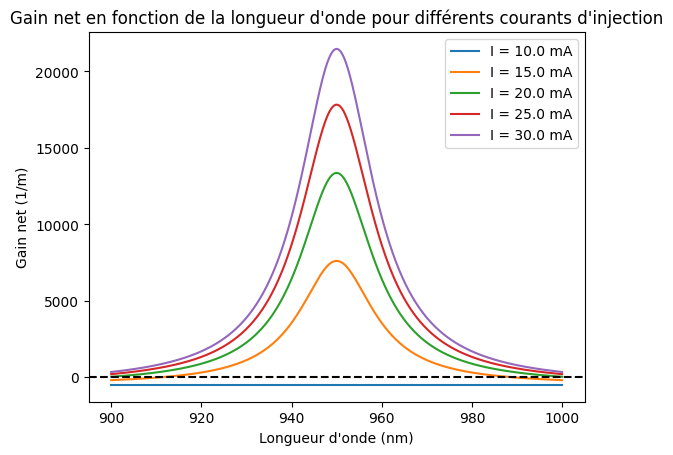

In [173]:
g_th = 5000 # 1/m

gain_values = {}
for I in I_list:
    gain = gain_brute[I]
    net_gain = Γ * gain - α
    gain_values[I] = net_gain
    plt.plot(λ_array*1e9, net_gain, label=f"I = {I*1e3:.1f} mA")

plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Gain net (1/m)")
plt.title("Gain net en fonction de la longueur d'onde pour différents courants d'injection")
plt.legend()
plt.axhline(0, color='black', linestyle='--')
plt.show()

Il y a seulement quelques modes qui dépassent le gain seuil, donc seulement ces modes pourront amplifier la lumière et participer au fonctionnement du laser. Aussi plus le courrant est élevé, plus il y a une plage de longueur d'onde qui est au dessus du seuil qui sera amplifié.

##### 2.C (5%) Quel est le courant seuil du mode central de la cavité? Sur quelle plage de courant le laser est-il monomode (émet un seul mode laser)?

On regarde à la longueur d'onde central du laser, quel doit être le courant pour que le gain net soit plus grand que 0. On refait le même procédé pour les deux modes suivantes c'est à dire $m = 946 $ et $m = 948$.

In [174]:
m = [m_central - 1, m_central, m_central + 1]
λ_centraux = [λ_res[m_central - 1],  λ_res[m_central], λ_res[m_central + 1]]

print(f"λ_centraux = {λ_centraux}")

gain_net_centraux = [[]]* len(λ_centraux)

current_monomode = None
current_multimode = None
current_array = np.linspace(10e-3, 100e-3, 25)
for i in current_array:
    for j in range(len(λ_centraux)):
        (gain_net_centraux[j]).append(calculate_gain(λ_centraux[j], i, g_0, λ_0, Δλ, I_tr)*Γ - α)



for i in range(len(current_array)):
    print(f"Courant: {i*1e3:.2f} mA, nm, Gain net: {gain_net_centraux[1][i]:.2f} 1/m")

λ_centraux = [np.float64(9.503695881731786e-07), np.float64(9.493670886075951e-07), np.float64(9.483667017913594e-07)]
Courant: 0.00 mA, nm, Gain net: -500.00 1/m
Courant: 1000.00 mA, nm, Gain net: -500.00 1/m
Courant: 2000.00 mA, nm, Gain net: -500.00 1/m
Courant: 3000.00 mA, nm, Gain net: 5860.39 1/m
Courant: 4000.00 mA, nm, Gain net: 5843.66 1/m
Courant: 5000.00 mA, nm, Gain net: 5703.58 1/m
Courant: 6000.00 mA, nm, Gain net: 10677.05 1/m
Courant: 7000.00 mA, nm, Gain net: 10647.66 1/m
Courant: 8000.00 mA, nm, Gain net: 10401.50 1/m
Courant: 9000.00 mA, nm, Gain net: 14554.87 1/m
Courant: 10000.00 mA, nm, Gain net: 14515.29 1/m
Courant: 11000.00 mA, nm, Gain net: 14183.72 1/m
Courant: 12000.00 mA, nm, Gain net: 17800.82 1/m
Courant: 13000.00 mA, nm, Gain net: 17752.70 1/m
Courant: 14000.00 mA, nm, Gain net: 17349.65 1/m
Courant: 15000.00 mA, nm, Gain net: 20592.24 1/m
Courant: 16000.00 mA, nm, Gain net: 20536.78 1/m
Courant: 17000.00 mA, nm, Gain net: 20072.26 1/m
Courant: 18000.00 

Ok, c'était un test, pour faire du beau python, je vais définir une fonction qui calcul le courrant de seuil pour une certaine longueur d'onde. Je vais ensuite calculé les courrant seuil pour les deux modes adjagent et trouvé la plage de courrant monomode.

In [175]:
def find_threshold_current(λ, g_0, λ_0, Δλ, I_tr, Γ, α):
    """
    Trouve le courant seuil pour lequel le gain net devient supérieur à 0
    Retourne:
        I_th : courant seuil (A) où le gain net = 0
    """
    
    # Fonction du gain net
    def gain_net(I):
        g = calculate_gain(λ, I, g_0, λ_0, Δλ, I_tr)
        return Γ * g - α
    
    for I in np.linspace(5e-3, 15e-3, 100000):
        if gain_net(I) >= 0:
            I_th = I
            break
    else:
        I_th = None  # Si aucun courant ne satisfait la condition
    return I_th

Mode m = 946, λ = 950.37 nm : I_th = 10.25355 mA
Mode m = 947, λ = 949.37 nm : I_th = 10.25425 mA
Mode m = 948, λ = 948.37 nm : I_th = 10.26005 mA
Mode m = 948, λ = 948.37 nm : I_th = 10.26005 mA


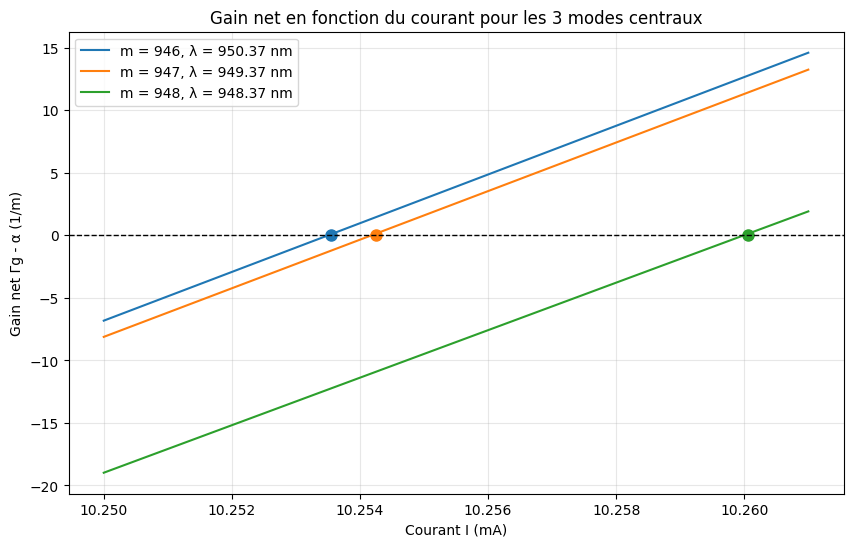

In [176]:
m = [m_central - 1, m_central, m_central + 1]
λ_centraux = [λ_res[m_central - 1], λ_res[m_central], λ_res[m_central + 1]]

# Trouver le courant seuil pour chaque longueur d'onde centrale
I_th_centraux = []
for i, λ in enumerate(λ_centraux):
    I_th = find_threshold_current(λ, g_0, λ_0, Δλ, I_tr, Γ, α)
    I_th_centraux.append(I_th)
    print(f"Mode m = {m[i]}, λ = {λ*1e9:.2f} nm : I_th = {I_th*1e3:.5f} mA")

# Visualisation du gain net en fonction du courant pour les 3 modes
current_array = np.linspace(10.25e-3, 10.261e-3, 200)


plt.figure(figsize=(10, 6))
for i, λ in enumerate(λ_centraux):
    gain_net_array = []
    for I in current_array:
        g = calculate_gain(λ, I, g_0, λ_0, Δλ, I_tr)
        gain_net = Γ * g - α
        gain_net_array.append(gain_net)
    
    line, = plt.plot(current_array*1e3, gain_net_array, label=f"m = {m[i]}, λ = {λ*1e9:.2f} nm")
    
    # Marquer le courant seuil avec la même couleur que la courbe
    if I_th_centraux[i] is not None:
        plt.plot(I_th_centraux[i]*1e3, 0, 'o', markersize=8, color=line.get_color())

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Courant I (mA)")
plt.ylabel("Gain net Γg - α (1/m)")
plt.title("Gain net en fonction du courant pour les 3 modes centraux")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


On trouve alors que la plage monomode est très petite

In [177]:

# Identification de la plage monomode
I_th_central = I_th_centraux[1]  
I_th_adjacent_min = min(I_th_centraux[0], I_th_centraux[2])  # Premier mode adjacent à atteindre le seuil

print(f"\n--- Plage de fonctionnement monomode ---")
print(f"Courant seuil du mode central (m = {m[1]}): I_th = {I_th_central*1e3:.5f} mA")
print(f"Courant seuil du premier mode adjacent: I_th_adj = {I_th_adjacent_min*1e3:.5f} mA")
print(f"Plage monomode: {I_th_central*1e3:.3f} mA < I < {I_th_adjacent_min*1e3:.5f} mA\n")
print(f"Largeur de la plage monomode: ΔI = {(np.abs(I_th_adjacent_min - I_th_central))*1e9:.2f} nA")



--- Plage de fonctionnement monomode ---
Courant seuil du mode central (m = 947): I_th = 10.25425 mA
Courant seuil du premier mode adjacent: I_th_adj = 10.25355 mA
Plage monomode: 10.254 mA < I < 10.25355 mA

Largeur de la plage monomode: ΔI = 700.01 nA


##### 2.D (5%) Proposez une méthode pour augmenter la plage d'opération monomode calculée en C. Justifiez avec un calcul.

En réduisant la longueur de la cavité FP, on peut espacer les modes et ainsi avoir une plage mono-mode plus grande.

In [178]:
L_test = [100,  50, 10, 5]  # en µm
L_test = [L_val*1e-6 for L_val in L_test]  # Convertir en m


# Boucle unique pour traiter chaque longueur de cavité
for L_cavity in L_test:
    m_central = calculate_m_central(λ_0, n_g, L_cavity)
    λ_central = (2 * n_g * L_cavity) / m_central
    FSR = calculate_FSR(λ_central, L_cavity, n_g)
    λ_centraux = [ (2 * n_g * L_cavity) / (m_central - 1),  (2 * n_g * L_cavity) / m_central, (2 * n_g * L_cavity) / (m_central + 1)]
    
    I_th_centraux = []
    for i, λ in enumerate(λ_centraux):
        I_th = find_threshold_current(λ, g_0, λ_0, Δλ, I_tr, Γ, α)
        I_th_centraux.append(I_th)
    
    I_th_central = I_th_centraux[1]  
    I_th_adjacent_min = min(I_th_centraux[0], I_th_centraux[2])  
    print(f"L = {L_cavity*1e6:.0f} µm : Plage monomode: {I_th_central*1e3:.3f} mA < I < {I_th_adjacent_min*1e3:.3f} mA | ΔI = {np.abs(I_th_adjacent_min - I_th_central)*1e6:.2f} μA | FSR = {FSR*1e9:.2f} nm")


L = 100 µm : Plage monomode: 10.254 mA < I < 10.254 mA | ΔI = 0.70 μA | FSR = 1.00 nm
L = 50 µm : Plage monomode: 10.254 mA < I < 10.258 mA | ΔI = 3.80 μA | FSR = 2.00 nm
L = 50 µm : Plage monomode: 10.254 mA < I < 10.258 mA | ΔI = 3.80 μA | FSR = 2.00 nm
L = 10 µm : Plage monomode: 10.271 mA < I < 10.396 mA | ΔI = 125.40 μA | FSR = 9.97 nm
L = 10 µm : Plage monomode: 10.271 mA < I < 10.396 mA | ΔI = 125.40 μA | FSR = 9.97 nm
L = 5 µm : Plage monomode: 10.396 mA < I < 10.662 mA | ΔI = 265.30 μA | FSR = 20.37 nm
L = 5 µm : Plage monomode: 10.396 mA < I < 10.662 mA | ΔI = 265.30 μA | FSR = 20.37 nm


In [179]:
#HERe

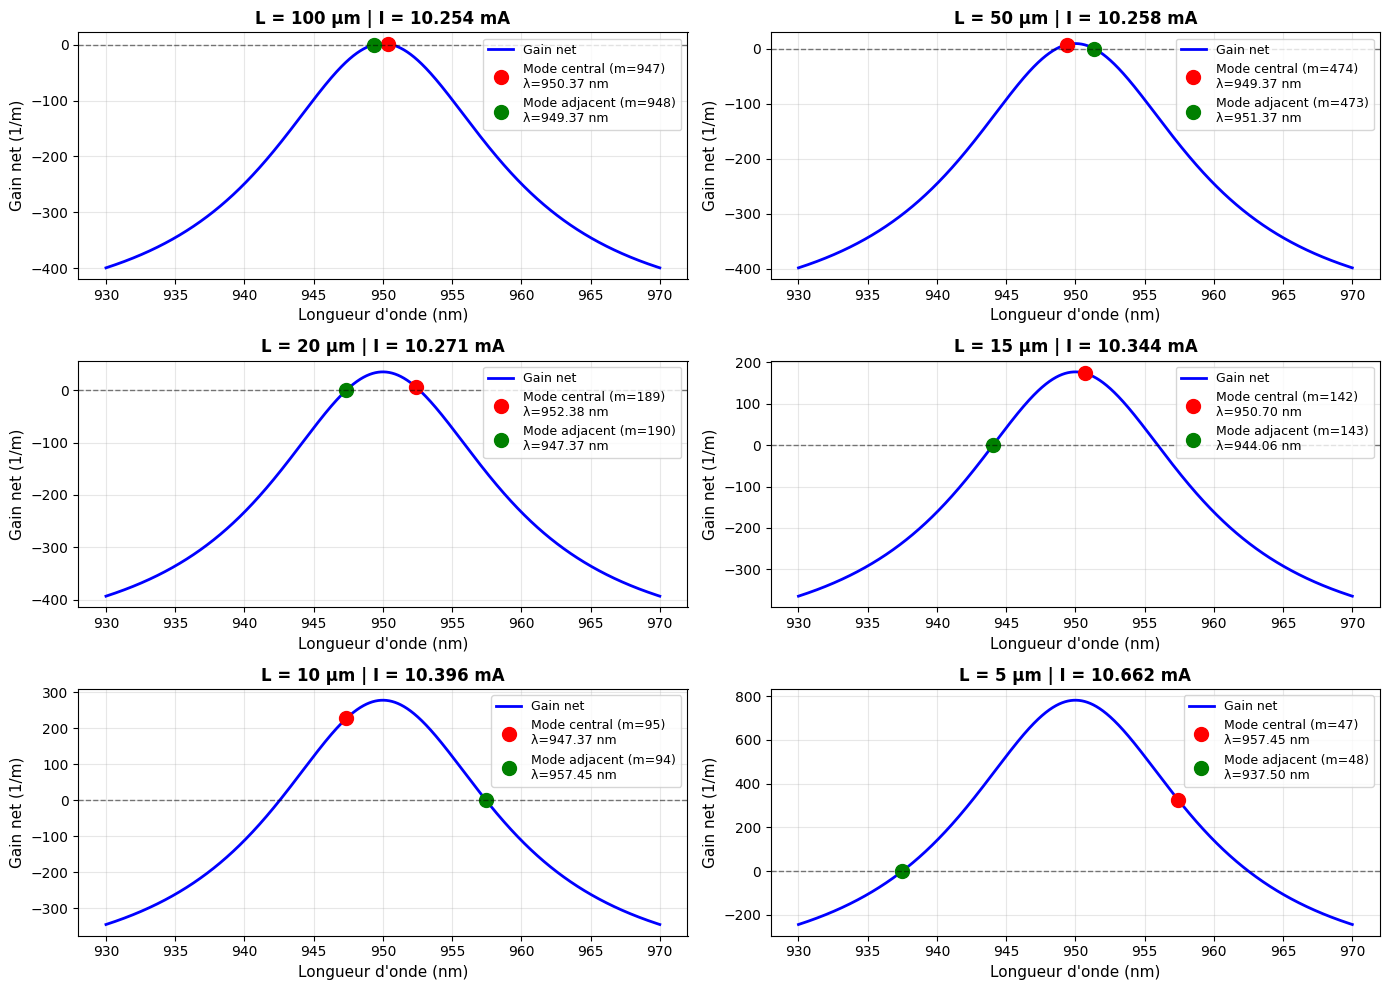


RÉSUMÉ DES RÉSULTATS POUR CHAQUE LONGUEUR DE CAVITÉ

L = 100 µm:
  Mode central: m = 947, λ = 950.37 nm, I_th = 10.254 mA
  Gain net du mode central @ I_th_adjacent_min: 1.46 1/m
  Mode adjacent: m = 948, λ = 949.37 nm
  I_th_adjacent_min = 10.254 mA
  FSR = 1.00 nm
  Plage monomode: ΔI = 0.70 µA

L = 100 µm:
  Mode central: m = 947, λ = 950.37 nm, I_th = 10.254 mA
  Gain net du mode central @ I_th_adjacent_min: 1.46 1/m
  Mode adjacent: m = 948, λ = 949.37 nm
  I_th_adjacent_min = 10.254 mA
  FSR = 1.00 nm
  Plage monomode: ΔI = 0.70 µA


KeyboardInterrupt: 

In [180]:
L_test = [100, 50,20,15, 10, 5]  # en µm
L_test_meters = [L_val*1e-6 for L_val in L_test]  # Convertir en m

# Plage de longueurs d'onde pour tracer le gain
λ_array = np.linspace(930e-9, 970e-9, 10000)

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, L_cavity in enumerate(L_test_meters):
    ax = axes[idx]
    
    # Calculer les modes résonants pour cette longueur de cavité
    m_central = calculate_m_central(λ_0, n_g, L_cavity)
    λ_res_cavity = (2 * n_g * L_cavity) / m_central
    
    # Longueurs d'onde des modes central et adjacents
    λ_central = (2 * n_g * L_cavity) / m_central
    λ_adjacent_1 = (2 * n_g * L_cavity) / (m_central - 1)
    λ_adjacent_2 = (2 * n_g * L_cavity) / (m_central + 1)
    
    # Identifier le mode adjacent le plus proche
    if abs(λ_adjacent_1 - λ_0) < abs(λ_adjacent_2 - λ_0):
        λ_adjacent_closest = λ_adjacent_1
        m_adjacent = m_central - 1
    else:
        λ_adjacent_closest = λ_adjacent_2
        m_adjacent = m_central + 1
    
    # Calculer les courants seuils
    λ_centraux_temp = [λ_adjacent_1, λ_central, λ_adjacent_2]
    I_th_centraux_temp = []
    for λ in λ_centraux_temp:
        I_th = find_threshold_current(λ, g_0, λ_0, Δλ, I_tr, Γ, α)
        I_th_centraux_temp.append(I_th)
    
    # Trouver I_th_adjacent_min
    I_th_central = I_th_centraux_temp[1]
    I_th_adjacent_min = min(I_th_centraux_temp[0], I_th_centraux_temp[2])
    
    # Calculer le gain net sur toute la plage λ_array à I_th_adjacent_min
    gain_net_array = []
    for λ in λ_array:
        g = calculate_gain(λ, I_th_adjacent_min, g_0, λ_0, Δλ, I_tr)
        gain_net = Γ * g - α
        gain_net_array.append(gain_net)
    
    # Tracer la courbe de gain
    ax.plot(λ_array*1e9, gain_net_array, 'b-', linewidth=2, label='Gain net')
    
    # Calculer et marquer le gain au mode central
    g_central = calculate_gain(λ_central, I_th_adjacent_min, g_0, λ_0, Δλ, I_tr)
    gain_net_central = Γ * g_central - α
    ax.plot(λ_central*1e9, gain_net_central, 'ro', markersize=10, 
            label=f'Mode central (m={m_central})\nλ={λ_central*1e9:.2f} nm')
    
    # Calculer et marquer le gain au mode adjacent le plus proche
    g_adjacent = calculate_gain(λ_adjacent_closest, I_th_adjacent_min, g_0, λ_0, Δλ, I_tr)
    gain_net_adjacent = Γ * g_adjacent - α
    ax.plot(λ_adjacent_closest*1e9, gain_net_adjacent, 'go', markersize=10,
            label=f'Mode adjacent (m={m_adjacent})\nλ={λ_adjacent_closest*1e9:.2f} nm')
    
    # Ligne de référence à gain = 0
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    # Annotations
    ax.set_xlabel('Longueur d\'onde (nm)', fontsize=11)
    ax.set_ylabel('Gain net (1/m)', fontsize=11)
    ax.set_title(f'L = {L_test[idx]} µm | I = {I_th_adjacent_min*1e3:.3f} mA', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

# Afficher un résumé des informations
print("\n" + "="*80)
print("RÉSUMÉ DES RÉSULTATS POUR CHAQUE LONGUEUR DE CAVITÉ")
print("="*80)
for idx, L_cavity in enumerate(L_test_meters):
    m_central = calculate_m_central(λ_0, n_g, L_cavity)
    λ_central = (2 * n_g * L_cavity) / m_central
    λ_adjacent_1 = (2 * n_g * L_cavity) / (m_central - 1)
    λ_adjacent_2 = (2 * n_g * L_cavity) / (m_central + 1)
    
    if abs(λ_adjacent_1 - λ_0) < abs(λ_adjacent_2 - λ_0):
        λ_adjacent_closest = λ_adjacent_1
        m_adjacent = m_central - 1
    else:
        λ_adjacent_closest = λ_adjacent_2
        m_adjacent = m_central + 1
    
    λ_centraux_temp = [λ_adjacent_1, λ_central, λ_adjacent_2]
    I_th_centraux_temp = []
    for λ in λ_centraux_temp:
        I_th = find_threshold_current(λ, g_0, λ_0, Δλ, I_tr, Γ, α)
        I_th_centraux_temp.append(I_th)
    
    I_th_central = I_th_centraux_temp[1]
    I_th_adjacent_min = min(I_th_centraux_temp[0], I_th_centraux_temp[2])
    
    FSR = calculate_FSR(λ_central, L_cavity, n_g)
    
    # Calculer le gain net du mode central à I_th_adjacent_min
    g_central_print = calculate_gain(λ_central, I_th_adjacent_min, g_0, λ_0, Δλ, I_tr)
    gain_net_central_print = Γ * g_central_print - α
    
    print(f"\nL = {L_test[idx]} µm:")
    print(f"  Mode central: m = {m_central}, λ = {λ_central*1e9:.2f} nm, I_th = {I_th_central*1e3:.3f} mA")
    print(f"  Gain net du mode central @ I_th_adjacent_min: {gain_net_central_print:.2f} 1/m")
    print(f"  Mode adjacent: m = {m_adjacent}, λ = {λ_adjacent_closest*1e9:.2f} nm")
    print(f"  I_th_adjacent_min = {I_th_adjacent_min*1e3:.3f} mA")
    print(f"  FSR = {FSR*1e9:.2f} nm")
    print(f"  Plage monomode: ΔI = {np.abs(I_th_adjacent_min - I_th_central)*1e6:.2f} µA")
print("="*80)

On voit que pour une longueur de cavité de $L = 10\ \rm{μm}$ on pourrait avoir un gain de $227 \ \rm{1/m}$ pour le mode central ce qui est bien meilleur que pour le cas original avec 
$g_{L=100μm} = 1.46 \ \rm{1/m}$

In [ ]:
reset_globals_variables()

### Question 3 - Laser Fabry-Perot (20%)
Considérez un laser de Fabry-Perot avec les caractéristiques suivantes:

| Paramètre du laser | Symbole | Valeur | Unités |
| --- | :----: | :---: | :---: |
|Dimensions transverses de la cavité | $d \times w$ | 0.2 $\times$ 1 | $\mu m$ |
|Efficacité d'injection | $\eta_i$ | 0.9 | -|
|Longueur de la cavité | $L$ | 500 | $\mu$ m |
|Coefficient de pertes | $\alpha_i$ | 10 | cm $^{-1}$ |
|Facteur de confinement | $\Gamma$ | 0.01 | - |
|Indice de groupe | $n_g$ | 3.65 | - |
|Coefficient de réflexion des miroirs | $r_{1,2}$ | 0.99, 0.8 | - |
|Temps de vie des porteurs | $\tau$ | 3 | ns |
|Longueur d'onde d'émission| $\lambda_0$ | 900 | nm |
|Densité de porteurs à la transparence| $N_{tr}$ | $1.1 \times 10^{18}$ | $ cm ^{-3}$ |
|Coefficient de gain nominal| $g_0$ | 2000 | $cm ^{-1}$ |

Utilisez un modèle de gain  logarithmique tel que vu en classe et assumez le cas limite $g\ge0 $ et négligez la compression du gain ($\epsilon = 0$). Faites l'analyse pour un seul mode.

In [ ]:
d = 0.2e-6
w = 1e-6
η_i = 0.9
L = 500e-6
α_i = 10 * 100 # 1/m
Γ = 0.01
n_g = 3.65
r_1 = 0.99
r_2 = 0.8
τ = 3e-9
λ_0 = 900e-9
N_tr = 1.1e18 * 1e6
g_0 = 2000 * 100

##### 3.A (5%) Calculer le courant de seuil du laser $I_{th}$.

Le courant seuil est trouvé à l'aide de l'équation $$ g(N) = g_0\ln{\cfrac{N}{N_{tr}}}\\ I_{th} = \cfrac{n_{th}eLWd}{τ_r}$$ à laquel il faut ajouter l'éfficacité d'injection.
$$ I_{th} = \cfrac{n_{th}eLWd}{η_iτ_r}$$
Nous avons besoin de la densité de porteur de charge threshold $n_{th}$. Celui-çi ce trouve avec l'équation 
$$g(n_{th}) = g_0\ln{\cfrac{n_{th}}{N_{tr}}}\\ e^{g_{th}/g_0}⋅N_{tr} = n_{th}$$
 où l'on trouve le gain seuil à l'aide des pertes dans la cavité $α$ avec la relation suivante $g_{th} = \frac{α_{tot}}{Γ}$.

$$α = α_m + α_i = -\frac{1}{L}\ln{(r_1r_2)} + α_i $$

In [ ]:
def calculate_threshold_current(d, w, L, α_int, Γ, g_0, N_tr, r_1, r_2, η, τ):
    """ Calcule le courant seuil I_th d'un laser à cavité Fabry-Perot

    Paramètres:
        d : épaisseur de la région active en m
        w : largeur de la région active en m
        L : longueur de la cavité en m
        α_i : pertes internes en 1/m
        Γ : facteur de confinement optique (sans unité)
        g_0 : gain optique par inversion de population en 1/m
        N_tr : densité de porteurs à la transparence en 1/m^3
        n_g : indice de groupe (sans unité)
        r_1, r_2 : coefficients de réflexion des miroirs (sans unité)
        η : efficacité de l'injection (sans unité)
        τ : temps de vie des porteurs en s

    Retourne:
        I_th : courant seuil en A
    """
    # Calcul des pertes totales
    α_tot = α_int - np.log(r_1 * r_2) / (L)
    print(f"Pertes totales α_tot = {α_tot:.2f} 1/m")

    # Calcul du gain au seuil
    g_thres = α_tot / Γ
    print(f"Gain au seuil g_th = {g_thres:.2f} 1/m")

    # Densité de porteurs au seuil
    N_thres = N_tr * np.exp(g_thres / g_0)
    # Volume de la région active
    print(f"Densité de porteurs au seuil N_th = {N_thres:.2e} 1/m^3")

    V_active = d * w * L

    # Courant seuil
    I_th = (N_thres * V_active * cte.e) / (η * τ)

    return I_th

In [ ]:
#Calcul perte total 1/m
α_tot = α_i - np.log(r_1*r_2)/(L) 
print(f"α_tot = {α_tot:.2f} 1/m")

g_th = α_tot / Γ  # en 1/m
print(f"Gain seuil = {g_th:.2f} 1/m")

N_th = N_tr*np.exp(g_th/g_0)
print(f"Densité de porteurs au seuil N_th = {N_th:.2e} m^-3")

I_th = (N_th * d * w * L * cte.e) / (η_i * τ)
print(f"Le courant seuil I_th est de {I_th*1e3:.2f} mA (calcul manuel)")

print("\n")
I_th = calculate_threshold_current(d, w, L, α_i, Γ, g_0, N_tr, r_1, r_2, η_i, τ)
print(f"Le courant seuil I_th est de {I_th*1e3:.2f} mA")


α_tot = 1466.39 1/m
Gain seuil = 146638.78 1/m
Densité de porteurs au seuil N_th = 2.29e+24 m^-3
Le courant seuil I_th est de 13.59 mA (calcul manuel)


Pertes totales α_tot = 1466.39 1/m
Gain au seuil g_th = 146638.78 1/m
Densité de porteurs au seuil N_th = 2.29e+24 1/m^3
Le courant seuil I_th est de 13.59 mA


##### 3.B (5%) Quelle est la puissance émise *par chaque facette* en régime permanent pour un courant appliqué de $I = 3 I_{th}$.

La fraction de la puissance qui sort par la facette 1 est donnée par l'équation
$$
F_1 = \frac{t_1^2}{(1-r_1^2)+\frac{r_1}{r_2} (1-r_2^2)} 
$$ 
Comme nous somme à incidence normal $t = \sqrt{1-r^2}$

Par la suite, pour trouvé l'actuelle puissance émise par la jonction sur une facette $j$ de Réflectivité $R_j = r_j^2$ avec l'éfficacité d'injection $η_i$ la formule est

$$P_j = η_i\frac{hν}{e}(I-I_{th}) \frac{α_{m_j}}{α_{tot}}$$

avec $ν = c/λ$

[$$ P_j = (I-I_{th}) \cfrac{η_ihc^2τ_{ph}(1-R_j)}{2enλL}$$]::



In [ ]:
def calculate_power_facette(I, I_th, τ_ph, λ, n_g, r_i, L, η_i=1.0):
    """ Calcule la puissance de sortie P_out d'un laser à cavité Fabry-Perot

    Paramètres:
        I : courant d'injection en A
        I_th : courant seuil en A
        τ_ph : temps de vie des photons en s
        λ : longueur d'onde en m
        n_g : indice de groupe (sans unité)
        r_i : coefficient de réflexion du miroir de sortie (sans unité)

    Retourne:
        P_out : puissance de sortie en W
    """
    # À incidence normal
    R_i = r_i**2

    if I <= I_th:
        return 0.0  # Pas d'émission laser en dessous du seuil

    P_out = (I - I_th) * (η_i * cte.h * cte.c**2 * τ_ph * (1 - R_i)) / (2 * cte.e * n_g * λ * L)

    return P_out


def calculate_α_miroir(r, L_α):
    return 1 / (L_α) * np.log(1 / (r))  # en 1/m

def calculate_power_interface(η_injection, λ, I, I_th, r, α_tot, L_p):
    """ Calcule la puissance de sortie P_j d'un laser à cavité Fabry-Perot pour un miroir j

    Paramètres:
        η_i : efficacité d'injection (sans unité)
        n_g : indice de groupe (sans unité)
        λ : longueur d'onde en m
        I : courant d'injection en A
        I_th : courant seuil en A
        r : coefficient de réflexion du miroir j (sans unité)
        α_tot : pertes totales en 1/m
        L : longueur de la cavité en m

    Retourne:
        P_j : puissance de sortie en W
    """
    if I <= I_th:
        return 0.0  # Pas d'émission laser en dessous du seuil

    α_m_j = calculate_α_miroir(r, L_p)
    
    P_j = (I - I_th) * η_injection * (cte.h * cte.c) / (cte.e * λ)  * (α_m_j / α_tot)

    return P_j

Temps de vie des photons τ_ph = 8.30 ps
La puissance de sortie P_out pour r_2 = 0.8 est de 10.255 mW
La puissance de sortie P_out pour r_1 = 0.99 est de 0.462 mW


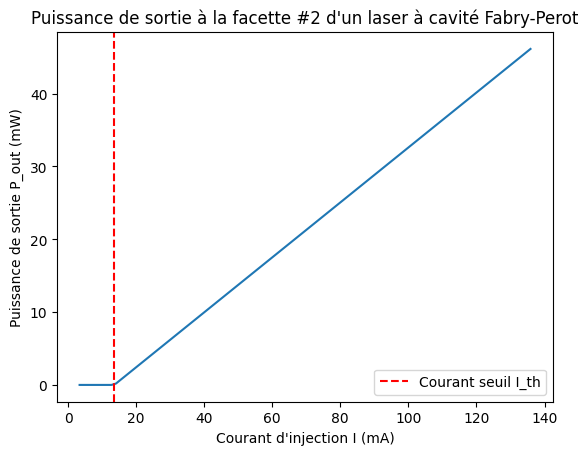

In [ ]:
I = 3 * I_th  # en A



# trouvé le temps de vie des photons τ_ph à partir de α_tot
v_g = cte.c / n_g  # Vitesse de groupe
τ_ph = 1 / (v_g * α_tot)  # en s
print(f"Temps de vie des photons τ_ph = {τ_ph*1e12:.2f} ps")

P_out_2 = calculate_power_interface(η_i, λ_0, I, I_th, r_2, α_tot, L)
P_out_1 = calculate_power_interface(η_i, λ_0, I, I_th, r_1, α_tot, L)

print(f"La puissance de sortie P_out pour r_2 = {r_2} est de {P_out_2*1e3:.3f} mW")
print(f"La puissance de sortie P_out pour r_1 = {r_1} est de {P_out_1*1e3:.3f} mW")

I_array = np.linspace(I_th/4, 10*I_th, 100)

P_out_array = []
for I_val in I_array:
    P_out = calculate_power_interface(η_i, λ_0, I_val, I_th, r_2, α_tot, L)
    P_out_array.append(P_out)

plt.plot(I_array*1e3, np.array(P_out_array)*1e3)
plt.xlabel("Courant d'injection I (mA)")
plt.ylabel("Puissance de sortie P_out (mW)")
plt.title("Puissance de sortie à la facette #2 d'un laser à cavité Fabry-Perot")
plt.axvline(I_th*1e3, color='red', linestyle='--', label='Courant seuil I_th')
plt.legend()
plt.show()



##### 3.C (5%) Quelle est l'efficacité quantique différentielle du laser? Quelle est la limite théorique maximale de l'efficacité quantique différentielle du laser?

L'efficacité quantique différentiel est une mesure de l'efficacité du laser lorseque le courrant augmente au dessus du courrant seuil. La question est ambigu, est-ce que l'on parle de l'efficacité quantique différentiel interne ou externe ? Je vais assumé que l'on parle de externe.

$η_{EDQE}$  se calcul avec le ratio de l'augmentation du nombre de photon généré sur la variation du nombre de charge injecté pendant une seconde. Si on parle de l'efficacité différentielle total du laser, on doit prendre en compte l'efficacité interne et externe. Je vais donc prendre la puissance à la sortie de la facette 2 comme étant la sortie du laser et utiliserai cette puissance pour calculer l'éfficacité.

Selon la feuille de formule, l'efficacité quantique différentielle ce calcul selon 
$$η_{EDQE} = \frac{\text{Increase in number of output photons from diode per second}}{\text{Increase in number of injected electrons into diode per second}}$$
$$ η_{EDQE}  =  \frac{dP}{dI} \frac{eλ_0}{hc} = \frac{eλ_0}{hc}\frac{P_o}{I-I_{th}}  \ \left[\frac{W}{A}\frac{C⋅m}{J⋅s⋅m/s} = \frac{\cancel{J⋅A⋅s⋅m⋅s}}{\cancel{s⋅J⋅A⋅m⋅s}}  \right]$$


 On assume que l'énergie moyenne des photons est celui d'un photon à $λ_0 = 900\ nm$

 Nous savons qu'avec notre modèle extrèmement linéaire de puissance optique, la valeur de l'efficacité ser partout pareil, mais par habitude, je vais aussi calculer l'efficacité pour chaque courant. Cela pourrait être utile pour étudier les domaine non linéaire de la puissance d'un laser.

 Une autre formule pour l'efficacité différentiel du laser est l'efficacité d'injection multiplier par le ratio des perte au miroir  $$ η_{EDQE} = η_i \frac{α_2}{α_{tot}} $$ 


In [ ]:
def calculate_differential_η_power_current(P, λ_0, I, I_th):
    """ Calcule l'efficacité différentielle quantique externe η_EDQE

    Paramètres:
        P : puissance optique en W
        λ : longueur d'onde en m
        I : courant d'injection en A
        I_th : courant seuil en A

    Retourne:
        η_EDQE : efficacité différentielle quantique externe (sans unité)
    """
    η_EDQE = (cte.e * λ_0) / (cte.h * cte.c) * (P / (I - I_th))
    return η_EDQE

def calculate_differential_η_perte(η_i, α_1, α_2, α_int):
    """ Calcule l'efficacité différentielle quantique interne η_EDQI

    Paramètres:
        η_i : efficacité d'injection (sans unité)
        α_1, α_2 : pertes aux miroirs en 1/m
        α_int : pertes internes en 1/m

    Retourne:
        η_EDQI : efficacité différentielle quantique interne (sans unité)
    """
    α_lase = max(α_1, α_2) # La facette qui lase est celle avec les plus grandes pertes

    η_EDQI = η_i * (α_lase) / (α_1 + α_2 + α_int)
    return η_EDQI



Efficacité quantique interne différentiel du laser est η_QDQI = 27.39 %
L'efficacité quantique différentiel du laser est η_QDQE = 27.39 %


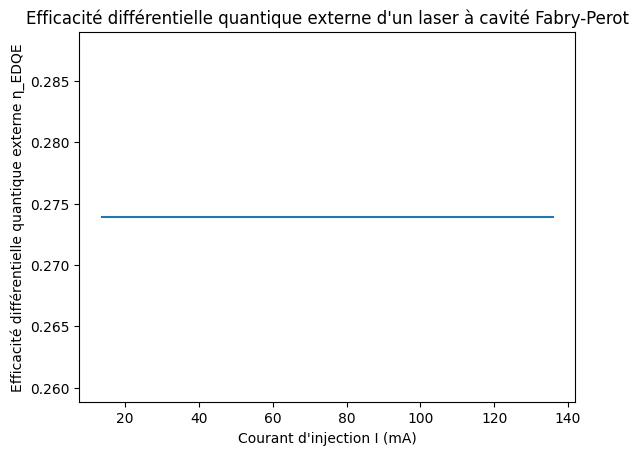

In [ ]:
I_array_2 = np.linspace(I_th*1.01, 10*I_th, 1000)

P_array_2 = np.zeros(len(I_array_2))
for i in range(len(I_array_2)):
    P_array_2[i] = calculate_power_interface(η_i, λ_0, I_array_2[i], I_th, r_2, α_tot, L)

η_EDQE_num3_2 = calculate_differential_η_perte(η_i, calculate_α_miroir(r_1, L), calculate_α_miroir(r_2, L), α_i)
print(f"Efficacité quantique interne différentiel du laser est η_QDQI = {η_EDQE_num3_2*100:.2f} %")

η_EDQE_num3 = calculate_differential_η_power_current(P_array_2, λ_0, I_array_2, I_th)
print(f"L'efficacité quantique différentiel du laser est η_QDQE = {η_EDQE_num3[0]*100:.2f} %")



plt.plot(I_array_2*1e3, η_EDQE_num3)
plt.xlabel("Courant d'injection I (mA)")
plt.ylabel("Efficacité différentielle quantique externe η_EDQE")
plt.title("Efficacité différentielle quantique externe d'un laser à cavité Fabry-Perot")
plt.show()


La limite théorique pour l'efficacité aura lieu dans le cas où $α_i =0, \ R_1 = 100\%, η_i =100\% , τ_{nr} = 0$.
Ainsi, l'entièreté des charges injecté dans la cavité se recombinerait dans la zone de dépétion avec la bonne énergie et produirait un photons. Aucune recombinaison serait non radiative. Comme il n'y aurait aucune perte, le miroir $R_2$ pourrait être très réfléchissant augmentant le facteur de qualité et l'entièreté des photons émis sortirait de la cavité par la facette $R_2$. Avec cette limite théorique, on obtiendrait un photon à la sortie pour chaque charge injecté. 
Ainsi pour chaque augmentation d'électron injecté, on obtiendrait l'augmentation d'un photon à la sortie. 
$$η_{EDQE} = \frac{\text{Increase in number of output photons from diode per second}}{\text{Increase in number of injected electrons into diode per second}}$$
ce qui donne $η_{EDQE} = 100\%$

##### 3.D (5%) Proposez une façon d'augmenter l'efficacité quantique différentielle. Supportez par un calcul.

Comme, on ne peux pas modifier les paramètres du semie-conducteur comme le taux de recombinaison non radiatif $τ_{nr}$ et l'efficacité d'injection $η_i$. 
Il est plus est plus facile de jouer avec les propritété des facettes. $$ η_{EDQE} = η_i \frac{α_2}{α_{tot}} =  η_i \frac{α_2}{α_{i} + α_i + α_2} $$ 

Pour augmenter l'éfficacité, on peut ainsi, diminuer $α_2$, diminuer $α_i$ ou augmenter $α_2$. Si on augmente $α_2$, c'est à dire diminuer $R_2$, on viens augmenté le nombre de photon émit par la facette $2$ par rapport au nombre de photon émit à l'intérieur de la cavité

In [ ]:
r_1_new = 0.9999
r_2_new = 0.8

η_EDQE_num3_new = calculate_differential_η_perte(η_i, calculate_α_miroir(r_1_new, L), calculate_α_miroir(r_2_new, L), α_i)

print(f"Pour r_1 = {r_1_new}, l'efficacité quantique interne différentiel du laser est η_QDQI = {η_EDQE_num3_new*100:.2f} %")
print(f"Comparé à l'ancienne valeur de r_1 = {r_1}, soit un augmentation de {(-(η_EDQE_num3_2-η_EDQE_num3_new))*100:.2f} %")

Pour r_1 = 0.9999, l'efficacité quantique interne différentiel du laser est η_QDQI = 27.77 %
Comparé à l'ancienne valeur de r_1 = 0.99, soit un augmentation de 0.38 %


In [ ]:
r_1_new = r_1
r_2_new = 0.5

η_EDQE_num3_new = calculate_differential_η_perte(η_i, calculate_α_miroir(r_1_new, L), calculate_α_miroir(r_2_new, L), α_i)

print(f"Pour r_1 = {r_2_new}, l'efficacité quantique interne différentiel du laser est η_QDQI = {η_EDQE_num3_new*100:.2f} %")
print(f"Comparé à l'ancienne valeur de r_1 = {r_2}, soit un augmentation de {(-(η_EDQE_num3_2-η_EDQE_num3_new))*100:.2f} %")

Pour r_1 = 0.5, l'efficacité quantique interne différentiel du laser est η_QDQI = 51.85 %
Comparé à l'ancienne valeur de r_1 = 0.8, soit un augmentation de 24.46 %


In [ ]:
reset_globals_variables()

### Question 4 -  Équation de taux d'une diode laser (50%)
Considérez une version simplifiée ($\Gamma = 1$, $G = \Gamma v_g g$) des équations de taux vues en classe:

$$ \frac{dN}{dt} = \eta_i \frac{I}{e} - \frac{N}{\tau} - G N_p$$
$$ \frac{dN_p}{dt} = R^{'}_{sp} + G N_p - \frac{N_p}{\tau_p}$$

Ici, $N$ et $N_p$ représente les quantités de porteurs et de photons et non les densités. Cette distinction est importante pour l'efficacité numérique de votre solution. 

Considérez un modèle linéaire pour le gain tel que:

$$ G(N) = \frac{G_0(N - N_{tr})}{1 + \epsilon N_p} $$

Ici $\epsilon$ est le facteur de compression du gain, à ne pas confondre avec la permittivité.

Les autres paramètres du laser sont:

| Paramètre du laser | Symbole | Valeur | Unités |
| --- | :----: | :---: | :---: |
|Temps de vie des photons | $\tau_p$ | 3 | ps |
|Temps de vie des porteurs | $\tau$ | 2 | ns |
|Taux d'émission spontanée | $R ^{'}_{sp}$ | 100 | ns $^{-1}$ |
|Facteur de gain | $G_0$ | $1 \times 10^{-5}$ | ns $^{-1}$ |
|Porteurs à la transparence| $N_{tr}$ | $4 \times 10^6$ | - |
|Efficacité d'injection | $\eta_i$ | 0.9 | - | 
|Facteur de compression du gain | $\epsilon$ | $2 \times 10^{-7}$ | - |
|Longueur d'onde d'émission | $\lambda_0$ | $1550$ | nm| 


In [226]:
# Paramètres globaux
τ_p = 3e-12
τ = 2e-9
R_sp_prime = 100e9 # en s^-1
G_0 = 1e-5*1e9  # en s^-1
N_tr = 4e6
η_i = 0.9
ϵ = 2e-7
λ_0 = 1550e-9

##### 4.A (2.5%) Calculer *analytiquement* le courant de seuil et la quantité de porteurs au seuil du laser.

$$ \frac{dN}{dt} = \eta_i \frac{I}{e} - \frac{N}{\tau} - v_g g N_p$$
$$ \frac{dN_p}{dt} = R^{'}_{sp} + v_g g N_p - \frac{N_p}{\tau_p}$$

Le courant de seuil est le courrant à partir du moment où le gain du laser deviens = 0, c'est à dire qu'il y a autant de perte que d'émission /amplification.

Le nombre de porteur au seuil ce calcul avec l'équation
$$ N_{th} = (N_2-n_1)_{th}  = \frac{8πn^2ν_0^2 R_{sp}'Δν}{c^2} $$
Ce qui n'est pas applicable dans notre situation car nous n'avons pas la largeur spectral $Δν$ de notre diode laser.

Le temps de vie des photons nous indique les pertes total. $$τ_p = \frac{1}{α_{tot}v_g} = \frac{1}{Γg_{th}v_g} $$

Au seuil, le nombre de photon qui sont amplifier par seconde (le gain G) doit être égal au nombre de perte de photon par seconde $τ_p$. C'est à dire que les perte de photons du à $τ_p$ sont contrbalancé par le gain $G(N_{th})$ 
$$ \frac{dN_p}{dt} = 0  \quad→\quad G(N_{th}) = \frac{1}{τ_p}$$

Ensuit, on prend l'équation du gain pour trouvé le nombre de carge au seuil
$$ G(N) = \frac{G_0(N - N_{tr})}{1 + \epsilon N_p} $$
Comme au seuil, nous sommes à très petit courant et très petit densité de porteur et que le nombre de photon est très petit, nous pouvons négligé $N_p$ dans cette équation.
$$ G(N_{th}) = \frac{G_0(N_{th} - N_{tr})}{1 } = \frac{1}{τ_p} $$
$$ N_{th} = \frac{1}{G_0τ_p} + N_{tr} =  \frac{1}{1×10^4⋅3×10^{-12}} + 4×10^6 =3.7\bar{3}×10^7  \ [\text{électrons}]  $$

In [227]:
N_th  = N_tr + (1 / (G_0 * τ_p))
print(f"Nombre de porteurs au seuil N_th = {N_th:.2e}")


Nombre de porteurs au seuil N_th = 3.73e+07


Ensuite pour le courant au seuil, on pourait utiliser $$I_{th} = \frac{n_{th}eLWd}{\tau_r}$$
mais comme nous n'avons pas les dimenstions de la cavitée, nous devons utilisé les équations de taux pour les porteurs de charge qui est $=0$ au seuil. Encore une fois, l'approximation que le nombre de photon au seuil est très petite est faite.
$$ \frac{dN_{th}}{dt} = 0 = \eta_i \frac{I}{e} - \frac{N_{th}}{\tau} - 0$$
$$I_{th} = \frac{eN_{th}}{\tau η_i} = \frac{e=1.602×10^{−19}⋅3.73×10^{7} }{2×10^{-9}⋅0.9} = 3.3197\ [\rm{mA}] $$



In [228]:
I_th = (cte.e * N_th ) / (η_i * τ)
print(f"Courant seuil I_th = {I_th*1e3:.3f} mA")

Courant seuil I_th = 3.323 mA


    ##### 4.B (2.5%) Quelle est la quantité de porteurs en régime permanent, au-delà du seuil? 

Encore une fois, en régime permanent, la variation de porteurs est nul. Toutefois, la quantité de photon ne peut plus être approximé à 0. 

On sait toutefois que au dessus du courant seuil, le gain sera limité au gain seuil et que la quantité de porteur de charge sera limité à celle du seuil. C'est la quantité de photon qui augmente on augmente le courant.

Au dessu du seuil:
$$ N = N_{th}\\ G =G_{th} $$

In [229]:
# - Réponse -

*Pour le reste du problème* (C, D, E, F, G, H), vous devez résoudre les équations de taux numériquement en utilisant une librairie de Python (scipy.integrate par exemple) ou la méthode de Runge-Kutta 4 vue en classe.


##### 4.C (10%)

On vous demande d'abord de tracer les valeurs en régime permanent de $N$ et de $N_p$ en fonction du courant $I$. Le courant devrait être varier entre $I = 0$ mA et $I = 10$ mA.

Comment se compare ce que vous observez avec les valeurs obtenues en A et en B?

*** Conseil: exprimez votre variable de temps en $ns$ au lieu d'en $s$, encore une fois afin d'éviter les erreurs d'overflow. Attention à la conversion du courant. ***

*** Pour obtenir les valeurs en régime permanent, il suffit de résoudre les équations en temps jusqu'à l'atteinte de l'état stationnaire, puis de conserver seulement une valeur en R.P. ***

*** Pour résoudre les équations de taux, vous pouvez utiliser l'intégrateur numérique Runge-Kutta ou utiliser une fonction du module scipy (par exemple, https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)

Pour résoudre les équations numériques, on doit définir les deux équations différentiel et résoudre avec un intégrateur numérique. 
$$ G(N) = \frac{G_0(N - N_{tr})}{1 + \epsilon N_p} $$

L'équation prend en entré l'état présent $N$ et $N_p$ et retourne la dérivé de celle-çi par rapport au temps.
$$ \frac{dN}{dt} = \eta_i \frac{I}{e} - \frac{N}{\tau} - G N_p$$
$$ \frac{dN_p}{dt} = R^{'}_{sp} + G N_p - \frac{N_p}{\tau_p}$$

Ensuite il reste définir des conditions initiales à intégrer avec une certaine méthode numérique.



In [230]:
def calculate_derivate_quantités(Input_vector, t, I, η_i, τ, R_sp_prime, G_0, N_tr, ϵ, τ_p):
    """ Calcule les dérivées dN/dt et dN_p/dt

    Paramètres:
        N : nombre de porteurs
        N_p : nombre de photons
        I : courant d'injection en A
        η_i : efficacité d'injection (sans unité)
        τ : temps de vie des porteurs en s
        R_sp_prime : taux de recombinaison spontanée en s^-1
        G_0 : gain optique par inversion de population en s^-1
        N_tr : densité de porteurs à la transparence (sans unité)
        ϵ : coefficient de saturation du gain (sans unité)
        τ_p : temps de vie des photons en s

    Retourne:
        dN_dt : dérivée du nombre de porteurs
        dN_p_dt : dérivée du nombre de photons

    """

    N = Input_vector[0]
    N_p = Input_vector[1]
    
    G = G_0 * (N - N_tr) / (1 + ϵ * N_p)

    dN_dt = η_i * I / cte.e - N / τ - G * N_p
    dN_p_dt = R_sp_prime + G * N_p - N_p / τ_p

    output_vector = np.array([dN_dt, dN_p_dt])
    return output_vector

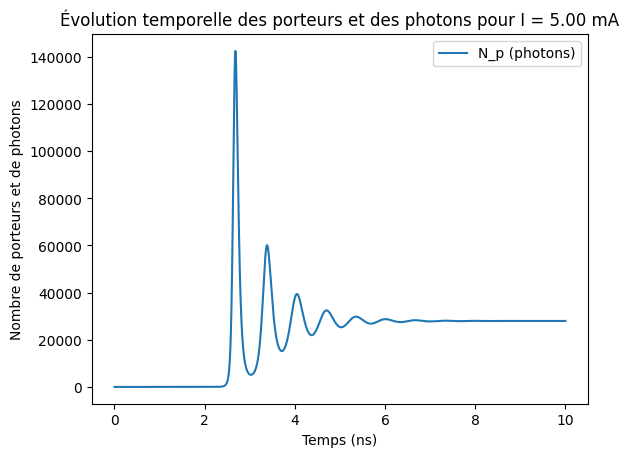

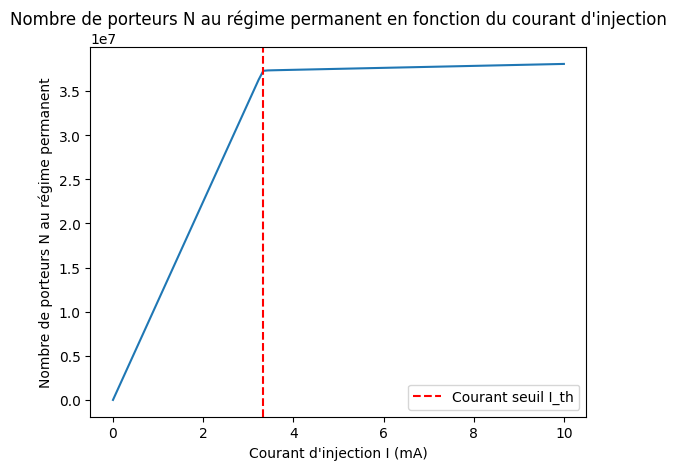

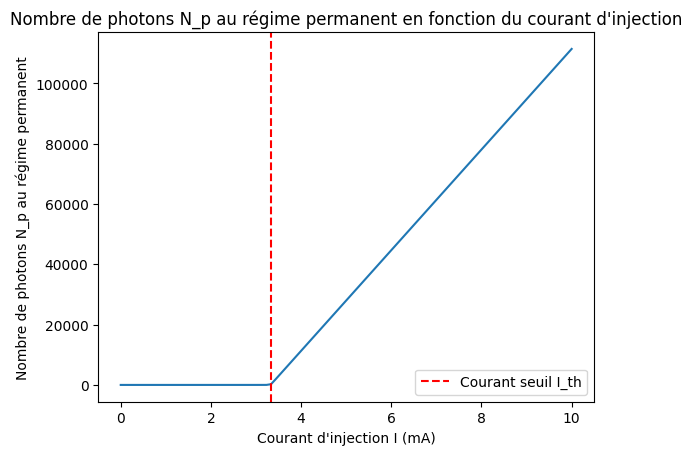

In [231]:
intial_state = [0, 0]  # N initial, N_p initial
simulation_time = 100E-9# 100 ns
time_points = np.linspace(0, simulation_time, 10000)  # de 0 à 100 ns

I_test = 5e-3  # Courant d'injection en A
current_array = np.linspace(0, 10E-3, 100)  # Courants d'injection en A

régime_permanent = []

solution = integrate.odeint(calculate_derivate_quantités, intial_state, time_points/10, args=(I_test, η_i, τ, R_sp_prime, G_0, N_tr, ϵ, τ_p))
#plot the result for I_test
N_t_test = solution[:, 0]
N_p_t_test = solution[:, 1]
plt.plot(time_points/10*1e9, N_p_t_test, label='N_p (photons)')
plt.xlabel("Temps (ns)")
plt.ylabel("Nombre de porteurs et de photons")
plt.title(f"Évolution temporelle des porteurs et des photons pour I = {I_test*1e3:.2f} mA")
plt.legend()
plt.show()



for i in current_array:
    # Résolution des équations différentielles
    solution = integrate.odeint(calculate_derivate_quantités, intial_state, time_points, args=(i, η_i, τ, R_sp_prime, G_0, N_tr, ϵ, τ_p))
    N_t = solution[:, 0]
    N_p_t = solution[:, 1]
    régime_permanent.append((N_t[-1], N_p_t[-1]))



# Régime permanent en fonction du courant
N_thres = []
N_p_thres = []
for état in régime_permanent:
    N_thres.append(état[0])
    N_p_thres.append(état[1])
plt.plot(current_array*1e3, N_thres, '-')
plt.xlabel("Courant d'injection I (mA)")
plt.ylabel("Nombre de porteurs N au régime permanent")
plt.title("Nombre de porteurs N au régime permanent en fonction du courant d'injection")
plt.axvline(I_th*1e3, color='red', linestyle='--', label='Courant seuil I_th')
plt.legend()
plt.show()

plt.plot(current_array*1e3, N_p_thres, '-')
plt.xlabel("Courant d'injection I (mA)")
plt.ylabel("Nombre de photons N_p au régime permanent")
plt.title("Nombre de photons N_p au régime permanent en fonction du courant d'injection")
plt.axvline(I_th*1e3, color='red', linestyle='--', label='Courant seuil I_th')
plt.legend()
plt.show()


Pour confirmé nos approimation regardons au courrant seuil

C:\Users\Éloi Blouin\AppData\Local\Temp\ipykernel_17556\3172688819.py:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = integrate.odeint(calculate_derivate_quantités, intial_state, time_points, args=(i, η_i, τ, R_sp_prime, G_0, N_tr, ϵ, τ_p))


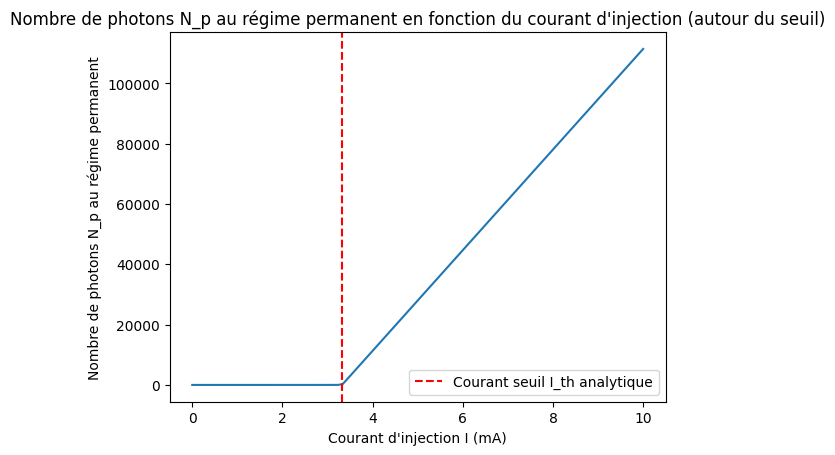

In [232]:
intial_state = [0, 0]  # N initial, N_p initial
simulation_time = 100  # 100 ns
time_points = np.linspace(0, simulation_time, 10000)  # de 0 à 100 ns

current_array_th = np.linspace(I_th*0.98, I_th*1.01, 100)  # Courants d'injection en A

régime_permanent_th = []

for i in current_array:
    # Résolution des équations différentielles
    solution = integrate.odeint(calculate_derivate_quantités, intial_state, time_points, args=(i, η_i, τ, R_sp_prime, G_0, N_tr, ϵ, τ_p))
    N_th = solution[:, 0]
    N_p_th = solution[:, 1]
    régime_permanent_th.append((N_th[-1], N_p_th[-1]))

# Régime permanent en fonction du courant
N_thresh_th = []
N_p_thresh_th = []
for état in régime_permanent:
    N_thresh_th.append(état[0])
    N_p_thresh_th.append(état[1])

plt.plot(current_array*1e3, N_p_thresh_th, '-')
plt.xlabel("Courant d'injection I (mA)")
plt.ylabel("Nombre de photons N_p au régime permanent")
plt.title("Nombre de photons N_p au régime permanent en fonction du courant d'injection (autour du seuil)")
plt.axvline(I_th*1e3, color='red', linestyle='--', label='Courant seuil I_th analytique')
plt.legend()
plt.show()

On remarque, le calcul analytique du courant de seuil a surprenament bien fonctionné.

##### 4.D (5%) Tracer la puissance de sortie totale du laser (en mW) en régime permanent en fonction du courant appliqué (en mA). Assumez $\tau_m \approx \tau_p$.

Nous connaissons la quantité de photon dans la cavité, avec le temps de vie des photons $τ_p$, on peut savoir combien de photon sont perdu par seconde. Ensuite on fait l'approximation que $α_i≈0$ ainsi 
$$ \frac{1}{τ_p} = \frac{1}{τ_i} + \frac{1}{τ_m} ≈ \frac{1}{τ_m} $$

Le nombre de photon qui sort de la cavité par seconde est ainsi
$$ flux_{phot, out} = \frac{N_p}{τ_p} = \frac{N_p}{τ_m} \ [\rm{phot/s}]$$

Pour la puissance, on multiplie le flux de photon par l'énergie de chaque photon avec encore une fois l'énergie moyenne des photon étant celle d'un photon à $λ_0$.
$$P_{out} = flux⋅\frac{hc}{λ_0} \ [\rm{W}]$$

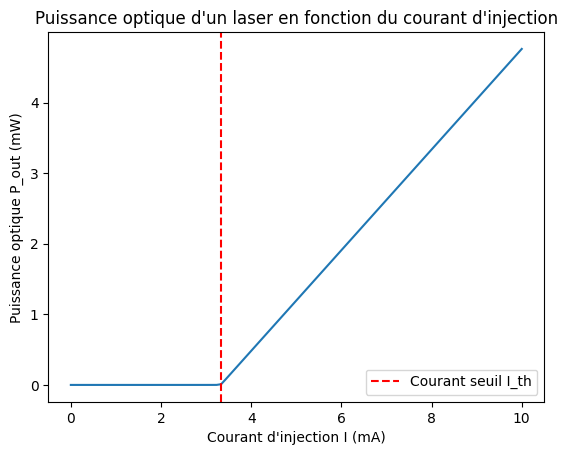

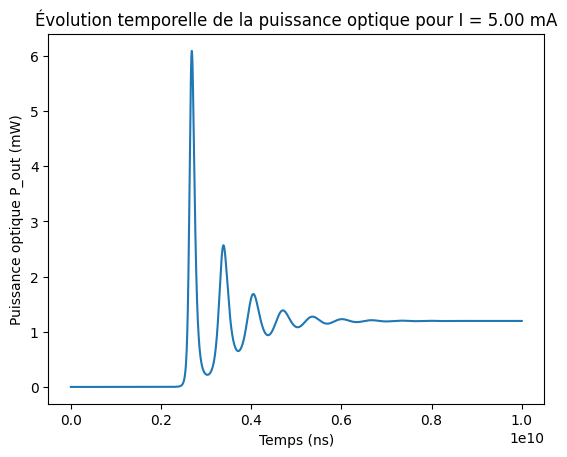

In [233]:
def calculate_optical_power(N_p, λ, τ_p):
    """ Calcule la puissance optique P_out d'un laser à cavité Fabry-Perot
    Paramètres:
        N_p : nombre de photons
        λ : longueur d'onde en m
        τ_p : temps de vie des photons en s
    Retourne:
        P_out : puissance optique en W
    """ 
    P_out = (N_p * cte.h * cte.c) / (λ * τ_p)
    return P_out

P_out_array = []
for N_p in N_p_thres:
    P_out = calculate_optical_power(N_p, λ_0, τ_p)
    P_out_array.append(P_out)

plt.plot(current_array*1e3, np.array(P_out_array)*1e3)
plt.xlabel("Courant d'injection I (mA)")
plt.ylabel("Puissance optique P_out (mW)")
plt.title("Puissance optique d'un laser en fonction du courant d'injection")
plt.axvline(I_th*1e3, color='red', linestyle='--', label='Courant seuil I_th')
plt.legend()
plt.show()

#N_p_t_test
P_out_test = calculate_optical_power(N_p_t_test, λ_0, τ_p)
plt.plot(time_points/10*1e9, P_out_test*1e3)
plt.xlabel("Temps (ns)")
plt.ylabel("Puissance optique P_out (mW)")
plt.title(f"Évolution temporelle de la puissance optique pour I = {I_test*1e3:.2f} mA")
plt.show()



##### 4.E (5%) Sur un graphique, tracer la densité de photons en fonction du temps pour des courants de $I = 2 I_{th}$ et de $I = 5 I_{th}$ (deux courbes). Il faut donc résoudre les équations de taux de 0 ns à 5 ns en partant avec des valeurs initiales de $[N_0, N_{p,0}] = [0,0]$. Quel est le délai d'ouverture dans les deux cas? Qu'en déduisez-vous?

In [234]:
def calculate_temps_ouverture(intensity_vector, time_vector, threshold_fraction=0.01):
    """ Calcule le temps d'ouverture d'un laser selon l'intensité en régime permanent

    Paramètres:
        Intensity_vector : vecteur d'intensité lumineuse
        time_vector : vecteur de temps correspondant
        threshold_fraction : fraction du maximum pour définir le seuil (par défaut 0.1)

    Retourne:
        t_opening : temps d'ouverture en s
    """
    I_RP = intensity_vector[-1]
    threshold = threshold_fraction * I_RP

    above_threshold_indices = np.where(intensity_vector >= threshold)[0]
    if len(above_threshold_indices) == 0:
        return None  # Aucun dépassement du seuil

    #t_start = 
    t_end = time_vector[above_threshold_indices[-1]]

    #t_opening = t_end - t_start
    return time_vector[above_threshold_indices[0]]

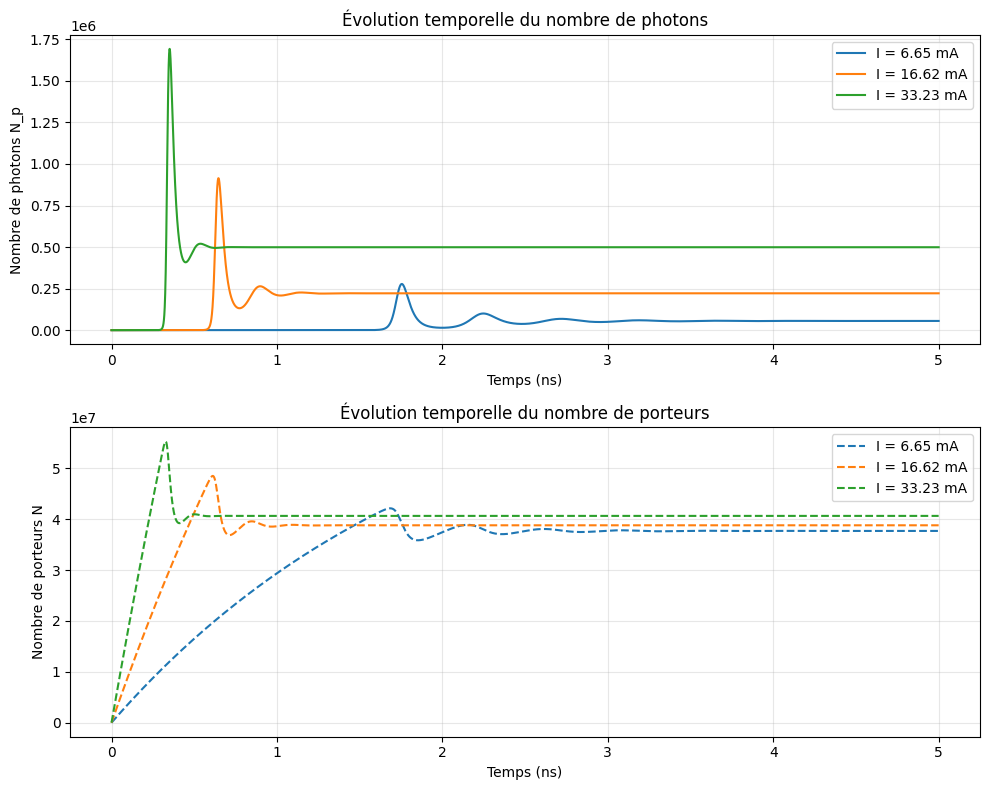


--- Temps d'ouverture pour différents courants d'injection ---
I = 6.65 mA : Temps d'ouverture = 1581.16 ps
I = 16.62 mA : Temps d'ouverture = 569.06 ps
I = 33.23 mA : Temps d'ouverture = 301.03 ps


In [235]:
initial_state_E = [0,0]
I_E = [2*I_th, 5*I_th, 10*I_th]  # Courants d'injection en A
simulation_time_E = 5E-9  #  ns
time_points_E = np.linspace(0, simulation_time_E, 10000)  # de 0 à 100 ns

temps_ouverture_results = {}

# Créer une figure avec deux subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
N_p_t_E_dict = {}
N_t_E_dict = {}

for I_val in I_E:
    solution_E = integrate.odeint(calculate_derivate_quantités, initial_state_E, time_points_E, args=(I_val, η_i, τ, R_sp_prime, G_0, N_tr, ϵ, τ_p))
    N_t_E = solution_E[:, 0]
    N_p_t_E = solution_E[:, 1]

    N_p_t_E_dict[I_val] = N_p_t_E
    N_t_E_dict[I_val] = N_t_E
    
    # Subplot 1 : Nombre de photons
    ax1.plot(time_points_E*1e9, N_p_t_E, label=f'I = {I_val*1e3:.2f} mA')
    
    # Subplot 2 : Nombre de porteurs
    ax2.plot(time_points_E*1e9, N_t_E, linestyle='--', label=f'I = {I_val*1e3:.2f} mA')
    
    temps_ouverture_results[I_val] = calculate_temps_ouverture(N_p_t_E, time_points_E)

# Configuration subplot 1 (Photons)
ax1.set_xlabel("Temps (ns)")
ax1.set_ylabel("Nombre de photons N_p")
ax1.set_title("Évolution temporelle du nombre de photons")
ax1.legend()
ax1.grid(True, alpha=0.3)
# Configuration subplot 2 (Porteurs)
ax2.set_xlabel("Temps (ns)")
ax2.set_ylabel("Nombre de porteurs N")
ax2.set_title("Évolution temporelle du nombre de porteurs")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n--- Temps d'ouverture pour différents courants d'injection ---")
for I_val, t_open in temps_ouverture_results.items():
    if t_open is not None:
        print(f"I = {I_val*1e3:.2f} mA : Temps d'ouverture = {t_open*1e12:.2f} ps")
    else:
        print(f"I = {I_val*1e3:.2f} mA : Pas de dépassement du seuil détecté")

Pour calculer le temps d'ouverture, on calcule le temps nécessaire pour que la puissance optique soit plus grande qu'un seuil de la puissance et régime permanent.

 On remarque que le temps d'ouverture est plus court lorsequ'on pompe les charges plus rapidement dans la cavité. Cela n'est pas vraiment surprenant, si l'on augmente le courant, le laser, commencera à laser plus rapidement. 

L'équation 4.18.2 du kasap nous donne une formule pour le temps d'ouverture
$$ t_d ≈ τ\ln\left( \frac{I_2}{I_2 - (I_{th} - I_1)} \right) $$
Dans notre cas le biais current est nul car nous démarons à partir de $I(t=0) = 0$. En encore avec l'approximation que $τ = τ_{ph}$, on confirme que l'ordre de grandeur est bon.


In [236]:

def calculate_temps_ouverture_théo(I_1, I_2, I_th,  τ):
    """ Calcule le temps d'ouverture théorique d'un laser

    Paramètres:
        I_1 : courant initial en A
        I_2 : courant final en A
        I_th : courant seuil en A
        τ : temps de vie des porteurs en s

    Retourne:
        t_d : temps d'ouverture théorique en s
    """
    t_d = τ * np.log(I_2 / (I_2 - (I_th - I_1)))
    return t_d

print("\n--- Temps d'ouverture théorique pour différents courants d'injection ---")
for I_val in I_E:
    t_open_théo = calculate_temps_ouverture_théo(0, I_val, I_th, τ)
    print(f"I = {I_val*1e3:.2f} mA : Temps d'ouverture théorique = {t_open_théo*1e12:.2f} ps, comparé à {temps_ouverture_results[I_val]*1e12:.2f} ps simulé")


--- Temps d'ouverture théorique pour différents courants d'injection ---
I = 6.65 mA : Temps d'ouverture théorique = 1386.29 ps, comparé à 1581.16 ps simulé
I = 16.62 mA : Temps d'ouverture théorique = 446.29 ps, comparé à 569.06 ps simulé
I = 33.23 mA : Temps d'ouverture théorique = 210.72 ps, comparé à 301.03 ps simulé


##### 4.F (5%) Tracer la puissance de sortie du laser en fonction du temps pour un courant appliqué de $I = 2 I_{th}$ et de $I = 5 I_{th}$. Estimer la fréquence des oscillations d'ouverture dans les deux cas. Qu'en déduisez-vous?

On veut programmer un fonction qui calcule la fréquences des oscillation. Une FFT ne semble pas être nécésaire comme nous avons peu de bruit. Je vais commencé par une fonction qui retournes les différents pics locaux. Ensuite calculé le delais entre chaque pics et finalement la fréquence de ces oscillation.

In [237]:
def find_local_maximum_minimum(X_vector, Y_vector):
    """ Trouve le maximum local dans un vecteur Y_vector

    Paramètres:
        X_vector : vecteur des abscisses
        Y_vector : vecteur des ordonnées

    Retourne:
        x_max : abscisse du maximum local
        y_max : ordonnée du maximum local
    """
    from scipy.signal import find_peaks

    peaks, _ = find_peaks(Y_vector, threshold=0.1)  # distance minimale entre les pics
    minimum, _ = find_peaks(-Y_vector, threshold=0.1)  # distance minimale entre les minima

    agregated_peaks = np.sort(np.concatenate((peaks, minimum)))

    if len(peaks) == 0:
        return None, None  # Aucun pic trouvé

    return agregated_peaks, Y_vector[agregated_peaks]

def calculate_oscillating_frequency(time_vector, intensity_vector):
    """ Calcule la fréquence d'oscillation à partir du vecteur d'intensité

    Paramètres:
        time_vector : vecteur de temps
        intensity_vector : vecteur d'intensité lumineuse

    Retourne:
        f_osc : fréquence d'oscillation en Hz
    """
    peaks_indices, peaks_values = find_local_maximum_minimum(time_vector, intensity_vector)
    if peaks_indices is None or len(peaks_indices) < 2:
        return None  # Pas assez de pics pour calculer la fréquence

    # Calculer les périodes entre les pics successifs
    periods = np.diff(time_vector[peaks_indices])
    # Comme la distance entre les peaks sont celle d'un maximum et minimum, on doit multiplier par 2 
    average_period = np.mean(periods)*2

    f_osc = 1 / average_period
    return f_osc, average_period

def calculate_oscillating_frequency_fft(time_vector, intensity_vector, plot_fft=False):
    """ Calcule la fréquence d'oscillation à partir du vecteur d'intensité en utilisant la FFT

    Paramètres:
        time_vector : vecteur de temps
        intensity_vector : vecteur d'intensité lumineuse
        plot_fft : booléen pour afficher le graphique FFT

    Retourne:
        f_osc : fréquence d'oscillation en Hz
    """
    # Nombre de points
    N = len(time_vector)
    dt = time_vector[1] - time_vector[0]
    # Fréquences associées à la FFT
    freq = np.fft.fftfreq(N, dt)

    fft_values = np.fft.fft(intensity_vector)
    amplitude = np.abs(fft_values)

    # Trouver la fréquence avec la plus grande amplitude (en ignorant la composante DC)
    positive_freq_indices = np.where(freq > 0)
    dominant_index = positive_freq_indices[0][np.argmax(amplitude[positive_freq_indices])]

    f_osc = freq[dominant_index]

    if plot_fft:
        # Filtrer les fréquences entre 1 GHz et 10 GHz
        max_freq = 20e9
        min_freq = 0.1e9
        # Combiner les deux conditions avec un ET logique
        trunck_indices = np.where((freq >= min_freq) & (freq <= max_freq))
        
        plt.plot(freq[trunck_indices]/1e9, amplitude[trunck_indices])
        plt.xlabel("Fréquence (GHz)")
        plt.ylabel("Amplitude FFT")
        plt.title("Transformée de Fourier de l'intensité (1-10 GHz)")
        plt.grid(True, alpha=0.3)
        plt.show()

    return f_osc

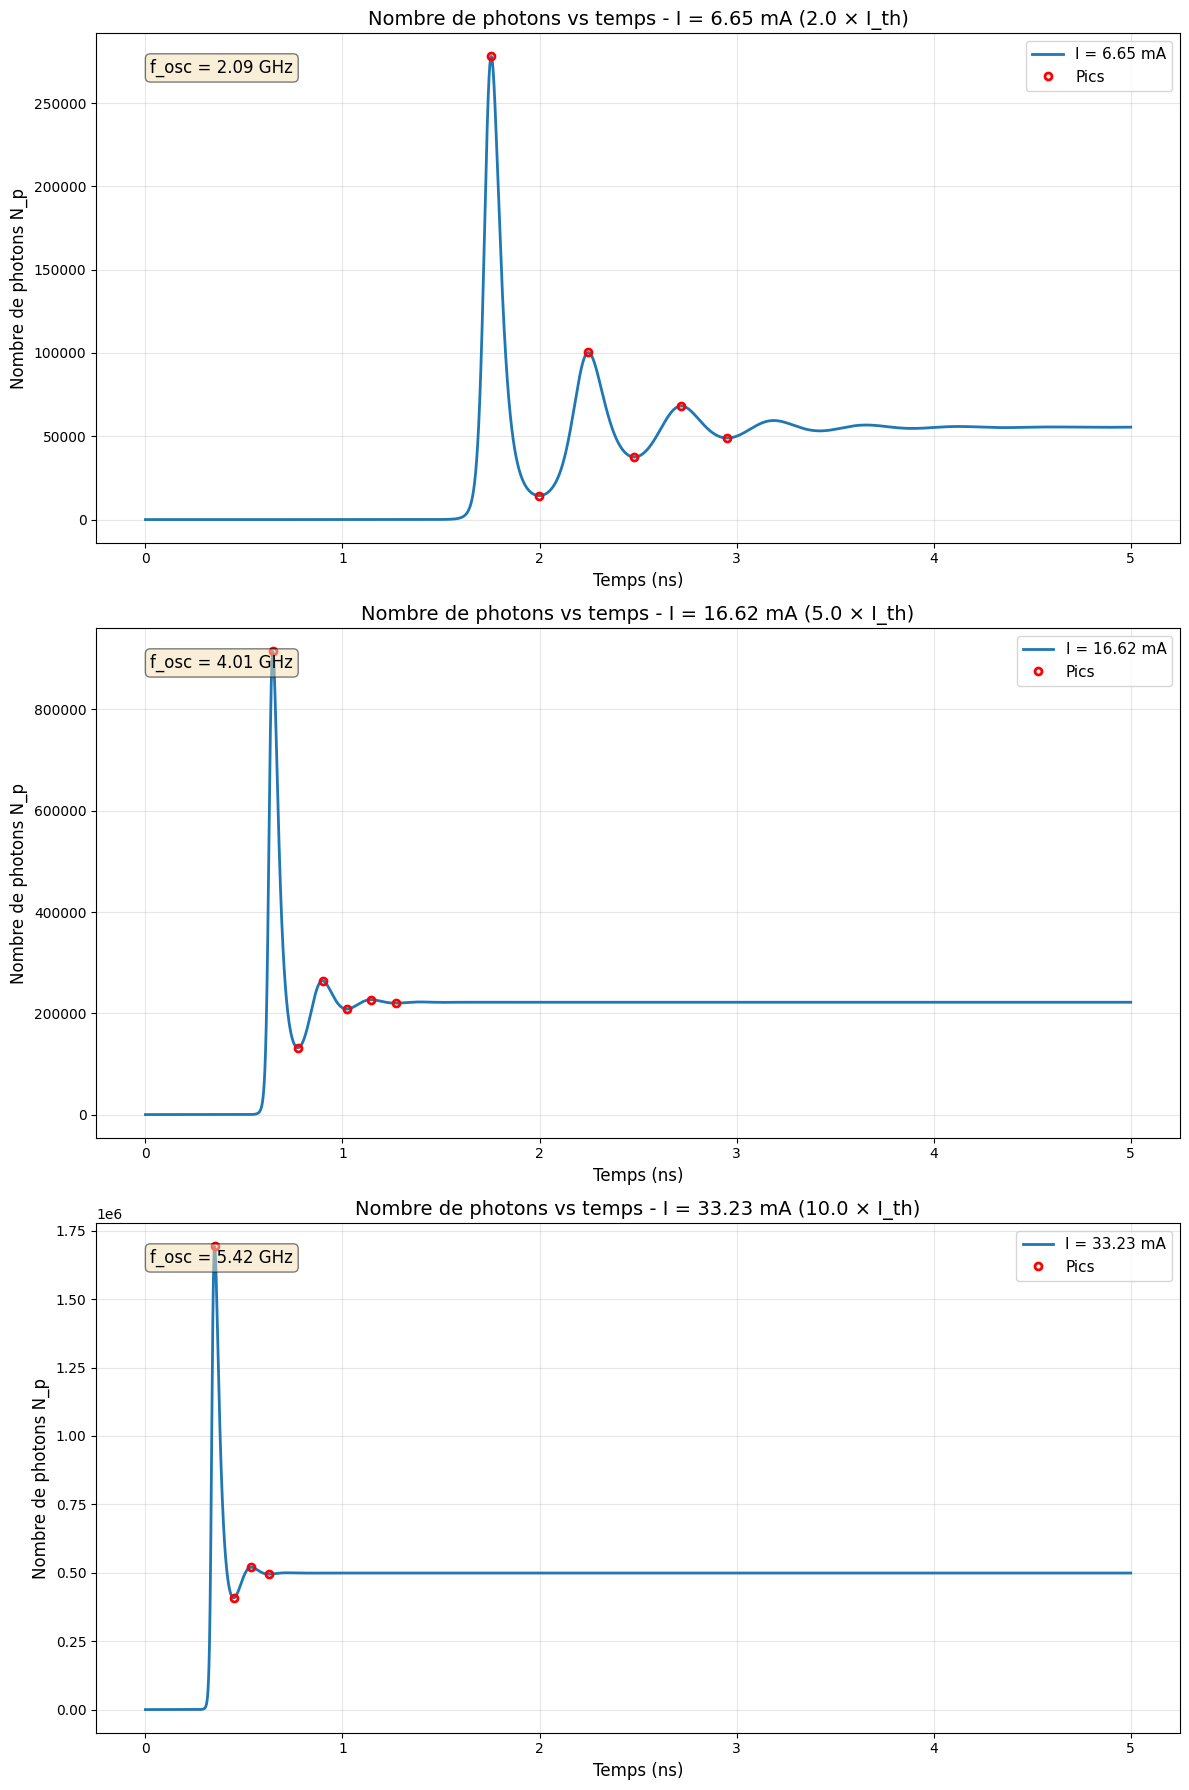

In [238]:
# Tracer le nombre de photons vs temps avec les pics pour chaque courant
fig, axes = plt.subplots(len(I_E), 1, figsize=(12, 6*len(I_E)))

# Si un seul courant, transformer axes en liste pour uniformiser le code
if len(I_E) == 1:
    axes = [axes]

for idx, I_val in enumerate(I_E):
    ax = axes[idx]
    
    # Obtenir les données pour ce courant
    N_p_data = N_p_t_E_dict[I_val]
    
    # Tracer le nombre de photons
    ax.plot(time_points_E*1e9, N_p_data, label=f'I = {I_val*1e3:.2f} mA', linewidth=2)
    
    # Trouver et marquer les pics
    peaks_indices, peaks_values = find_local_maximum_minimum(time_points_E, N_p_data)
    
    if peaks_indices is not None and len(peaks_indices) > 0:
        # Marquer les pics avec des cercles
        ax.plot(time_points_E[peaks_indices]*1e9, peaks_values, 'r.', 
                markersize=10, markerfacecolor='none', markeredgewidth=2,
                label='Pics')
        
        # Calculer et afficher la fréquence d'oscillation
        frequence_osc, _ = calculate_oscillating_frequency(time_points_E, N_p_data)
        if frequence_osc is not None:
            ax.text(0.05, 0.95, f'f_osc = {frequence_osc/1e9:.2f} GHz', 
                   transform=ax.transAxes, fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Configuration du graphique
    ax.set_xlabel("Temps (ns)", fontsize=12)
    ax.set_ylabel("Nombre de photons N_p", fontsize=12)
    ax.set_title(f"Nombre de photons vs temps - I = {I_val*1e3:.2f} mA ({I_val/I_th:.1f} × I_th)", fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



--- Fréquences d'oscillation pour différents courants ---


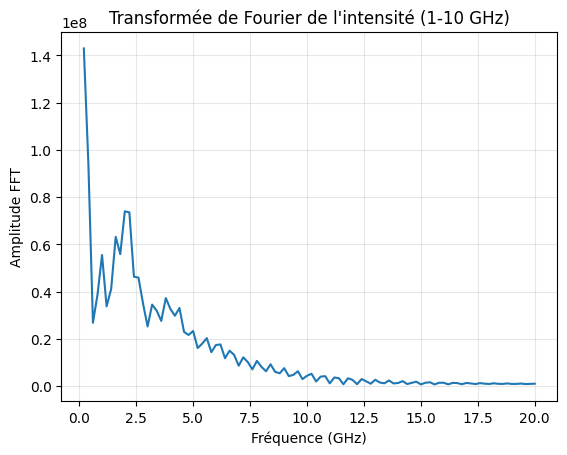

I = 6.65 mA (2.0 × I_th) : f_osc = 2.09 GHz, FFT = 0.20 GHz


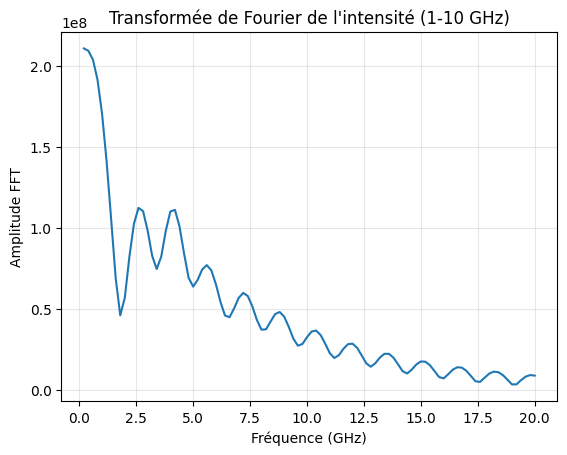

I = 16.62 mA (5.0 × I_th) : f_osc = 4.01 GHz, FFT = 0.20 GHz


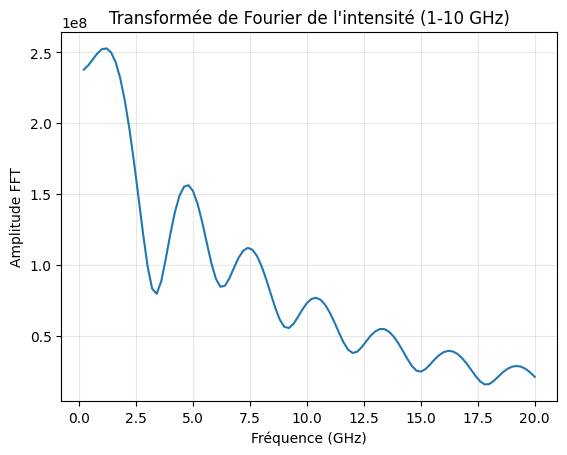

I = 33.23 mA (10.0 × I_th) : f_osc = 5.42 GHz, FFT = 1.20 GHz


In [239]:

# Afficher un résumé des fréquences d'oscillation
print("\n--- Fréquences d'oscillation pour différents courants ---")
for I_val in I_E:
    frequence_osc, _ = calculate_oscillating_frequency(time_points_E, N_p_t_E_dict[I_val])
    frequence_osc_fft = calculate_oscillating_frequency_fft(time_points_E, N_p_t_E_dict[I_val], plot_fft=True)
    if frequence_osc is not None:
        print(f"I = {I_val*1e3:.2f} mA ({I_val/I_th:.1f} × I_th) : f_osc = {frequence_osc/1e9:.2f} GHz, FFT = {frequence_osc_fft/1e9:.2f} GHz")
    else:
        print(f"I = {I_val*1e3:.2f} mA ({I_val/I_th:.1f} × I_th) : Pas d'oscillations détectées, FFT = {frequence_osc_fft/1e9:.2f} GHz")

Ensuite, on peut vérifier avec la FFT.

##### 4.G (5%) Tracer la réponse d'ouverture du laser: sur un graphique, tracer la quantité de photons vs la quantité de porteurs pour votre simulation faite en E, qu'observez-vous?

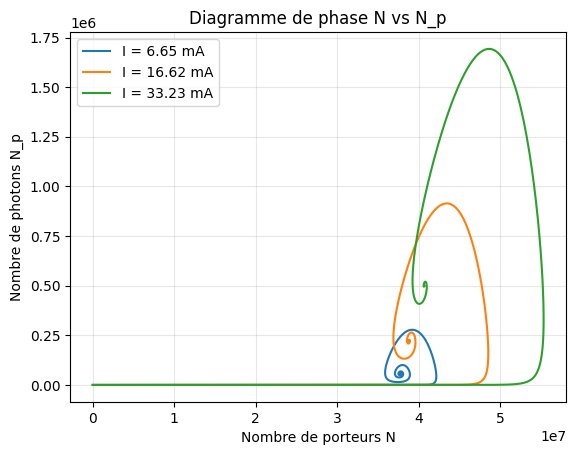

In [240]:
for I in I_E:
    plt.plot(N_t_E_dict[I], N_p_t_E_dict[I], label=f'I = {I*1e3:.2f} mA')
    plt.xlabel("Nombre de porteurs N")
    plt.ylabel("Nombre de photons N_p")
    plt.title("Diagramme de phase N vs N_p")
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.show()

On remarque que l'état stable est à un point où le nombre de photon est de plus en plus élevé. Aussi plus le courant augmente, plus le premier pique, l'oscillation deviens grande. On observe que 


##### 4.H (15%)
On vous demande maintenant de prédire la réponse fréquentielle du laser en modulation petit-signal, soit lorsque le courant appliqué a une petite composante AC superposée à une composante DC. On vous demande de le faire pour plusieurs valeurs de la composante DC: $I_{DC} = [1.2, 1.5, 2.5, 10] \times I_{th}$. 

Pour ce faire, appliqué d'abord le courant DC seulement et attendez que le laser atteigne l'état stationnaire. Ensuite, appliquez une petite perturbation au courant (un pulse). Continuer la simulation jusqu'à ce que les oscillations cessent (au moins 20 ns). Faites la transformée de Fourier des données à partir de l'introduction du pulse jusqu'à la fin de la simulation. On se rappel que la transformée de Fourier de la réponse temporelle d'un système avec une fonction delta appliquée nous donne la fréquence fréquentielle du système $S_{21}$.

Vous devez tracer la réponse fréquentielle pour chaque courant DC mentionné ci-haut et de trouver la fréquence de résonance du système. Comparez les résultats obtenus avec la réponse d'ouverture de votre laser, que remarquez-vous?


On commence par appliqué le courant DC, on enregistre le vecteur d'état en régime permanent qui contient la quantité de porteur de charge et la quantité de photon. Ensuite, on redémare une nouvelle simulatiion avec cette état inital et le nouveau courant

On va ce définir un vecteur temps et un vecteur courant.

À noter que si l'on met un delais grand entre le DC et l'impulsion, le sover ODE int voit une densité de charge et de photon très stable pendant un long temps et commence à prendre des interval de temps à diférentié plus long. Cela résulte que le solver ne voit pas l'impulsion du courant. Les solutions possibles à ce problèmes
- Utiliser un autre solver ivp [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) Par contre, il donne des résultats plus oscillante et même en régime permanent, il y a une variation de la puissance
- 

In [241]:
# Do the FFT of the N_p_t_H signal after the impulse
def fft_of_signal(time_vector, signal_vector):
    """ Calcule la FFT d'un signal et affiche le graphique si demandé

    Paramètres:
        time_vector : vecteur de temps
        signal_vector : vecteur du signal

    Retourne:
        freq : vecteur des fréquences
        amplitude : vecteur des amplitudes FFT
    """

    N = len(time_vector)
    dt = time_vector[1] - time_vector[0]
    freq = np.fft.fftfreq(N, dt)

    fft_values = np.fft.fft(signal_vector)
    amplitude = np.abs(fft_values)

    return freq, amplitude

def plot_fft(fréquence, amplitude):
    plt.plot(fréquence/1e9, amplitude)
    plt.xlabel("Fréquence (GHz)")
    plt.ylabel("Amplitude FFT [dB]")
    plt.title("Transformée de Fourier du signal après l'impulsion")
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 10) 
    plt.show()

def plot_fft_log_log(fréquence, amplitude):
    plt.loglog(fréquence/1e9, amplitude)
    plt.xlabel("Fréquence (GHz)")
    plt.ylabel("Amplitude FFT [dB]")
    plt.title("Transformée de Fourier du signal après l'impulsion (log-log)")
    plt.grid(True, alpha=0.3)
    plt.xlim(0.1, 10) 
    plt.show()

Amplitude impulsion: 0.01 A


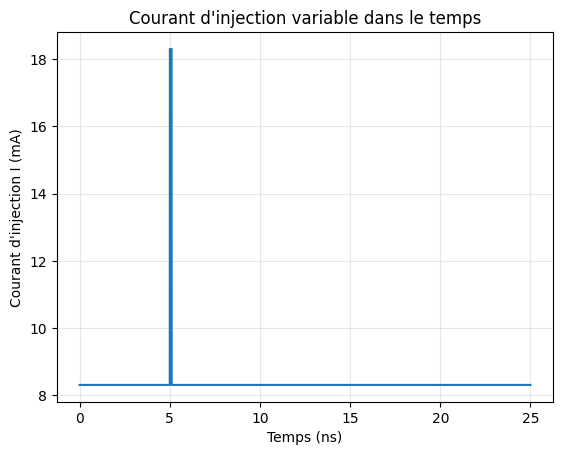

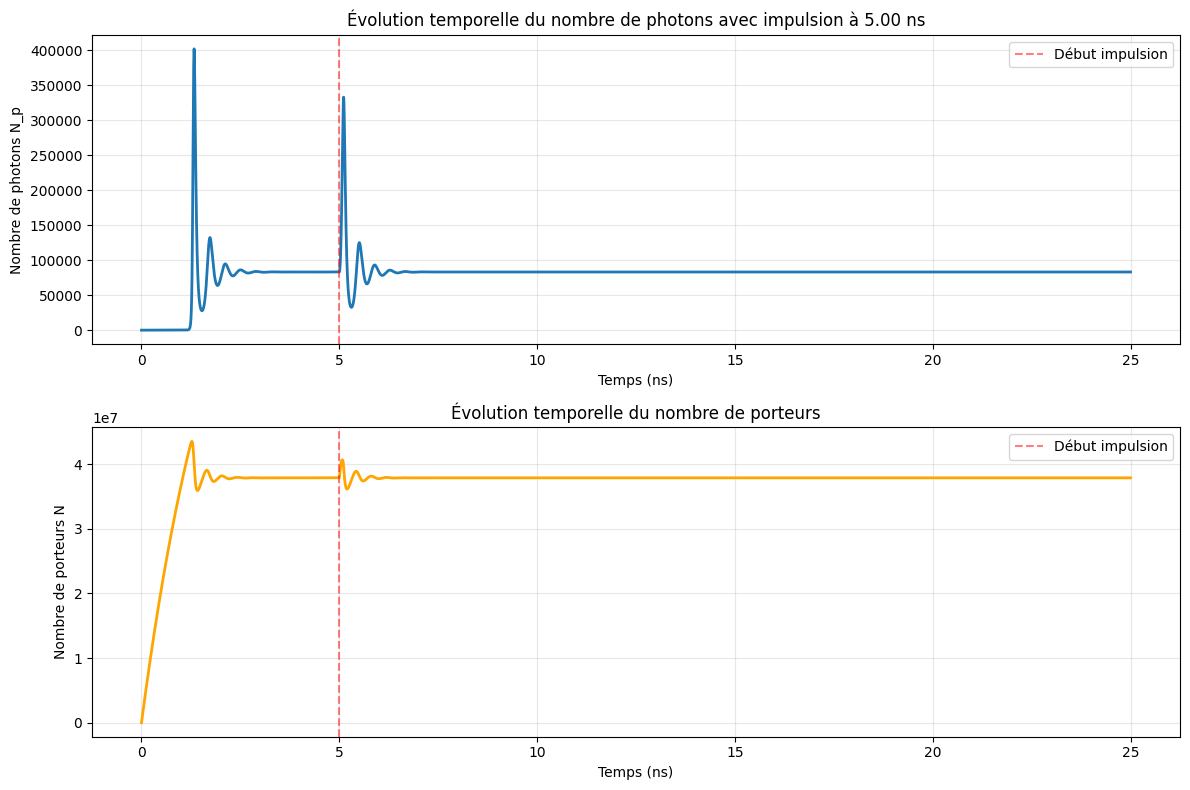

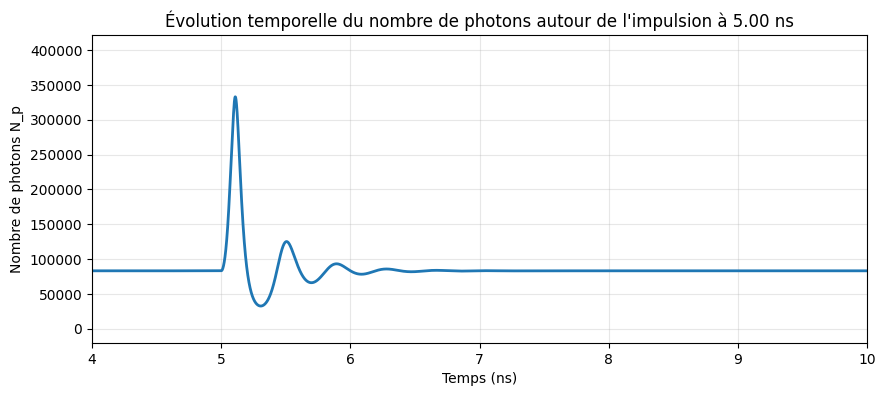

Nombre de points FFT: 796000


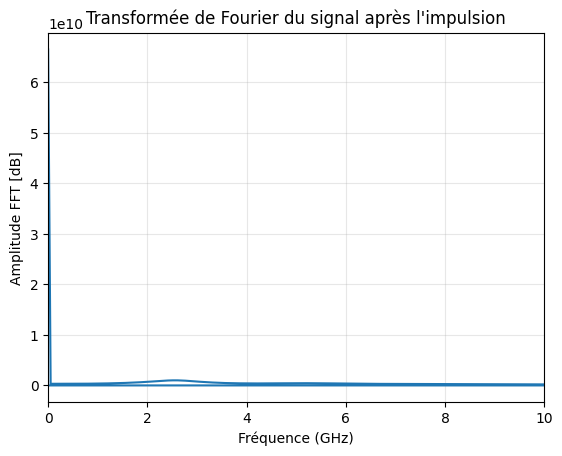

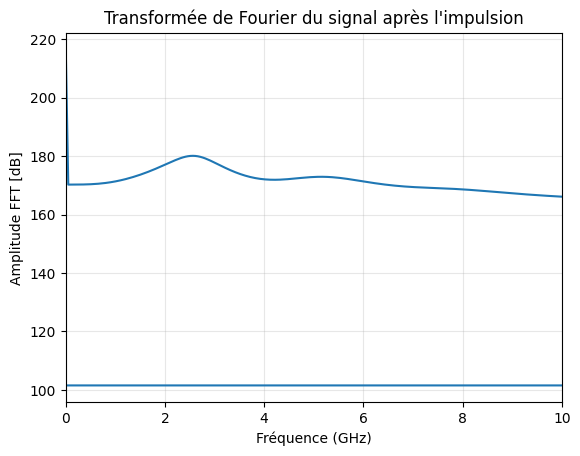

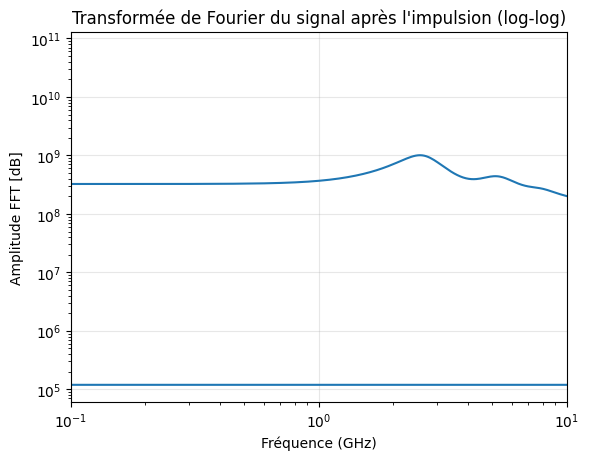

In [242]:
I_DC = 2.5*I_th  # Courant d'injection en A
delay_impulsion = 5E-9  # 20 ns
durée_impulsion = 100e-12  #  ns
current_impulsion = 10e-3  # A

time_points_H = np.linspace(0, delay_impulsion+20e-9, 1000000) 
print(f"Amplitude impulsion: {current_impulsion:.2f} A")

t_current_steps = [
    0.0, 
    delay_impulsion, 
    delay_impulsion + durée_impulsion, 
    time_points_H[-1] # Le temps final
]
I_current_values = [
    I_DC,                      # Valeur avant t=delay_impulsion
    I_DC + current_impulsion,  # Valeur entre delay et fin_impulsion
    I_DC,                      # Valeur après fin_impulsion
    I_DC                       # Valeur à la toute fin
]

# Créer une fonction en escalier
current_interpolator = interp.interp1d(
    t_current_steps, 
    I_current_values,
    kind='previous',
    bounds_error=False,
    fill_value=I_DC 
)

#plot the current vs time
plt.plot(time_points_H*1e9, current_interpolator(time_points_H)*1e3)
plt.xlabel("Temps (ns)")
plt.ylabel("Courant d'injection I (mA)")
plt.title("Courant d'injection variable dans le temps")
plt.grid(True, alpha=0.3)
plt.show()


# État initial
initial_state_H = [0, 0]  # N initial, N_p initial

# Nouvelle fonction dérivée qui accepte une FONCTION de courant
def calculate_derivate_quantités_time_varying(Input_vector, t, current_func, η_i, τ, R_sp_prime, G_0, N_tr, ϵ, τ_p):
    N = Input_vector[0]
    N_p = Input_vector[1]
    
    # Obtenir le courant au temps t (précis) via l'interpolation
    I = current_func(t)
    
    # ... (reste de votre fonction) ...
    G = G_0 * (N - N_tr) / (1 + ϵ * N_p)
    if G < 0: G = 0
    
    dN_dt = η_i * I / cte.e - N / τ - G * N_p
    dN_p_dt = R_sp_prime + G * N_p - N_p / τ_p

    return [dN_dt, dN_p_dt]


# Résoudre avec le courant variable
solution_H = integrate.odeint(
    calculate_derivate_quantités_time_varying, 
    initial_state_H, 
    time_points_H, 
    args=(current_interpolator, η_i, τ, R_sp_prime, G_0, N_tr, ϵ, τ_p)
)

N_t_H = solution_H[:, 0]
N_p_t_H = solution_H[:, 1]

# Tracer les résultats
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Subplot 1: Nombre de photons
ax1.plot(time_points_H*1e9, N_p_t_H, linewidth=2)
ax1.axvline(delay_impulsion*1e9, color='red', linestyle='--', alpha=0.5, label='Début impulsion')
ax1.set_xlabel("Temps (ns)")
ax1.set_ylabel("Nombre de photons N_p")
ax1.set_title(f"Évolution temporelle du nombre de photons avec impulsion à {delay_impulsion*1e9:.2f} ns")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2: Nombre de porteurs
ax2.plot(time_points_H*1e9, N_t_H, linewidth=2, color='orange')
ax2.axvline(delay_impulsion*1e9, color='red', linestyle='--', alpha=0.5, label='Début impulsion')
ax2.set_xlabel("Temps (ns)")
ax2.set_ylabel("Nombre de porteurs N")
ax2.set_title("Évolution temporelle du nombre de porteurs")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# subplot du nombre de photons autour de l'impulsion
plt.figure(figsize=(10, 4))
plt.plot(time_points_H*1e9, N_p_t_H, linewidth=2)
plt.xlim((delay_impulsion - 1E-9)*1e9, (delay_impulsion + 5E-9)*1e9)
plt.xlabel("Temps (ns)")
plt.ylabel("Nombre de photons N_p")
plt.title(f"Évolution temporelle du nombre de photons autour de l'impulsion à {delay_impulsion*1e9:.2f} ns")
plt.grid(True, alpha=0.3)
plt.show()



# Extraire la partie du signal après l'impulsion
post_impulsion_indices = np.where(time_points_H >= (delay_impulsion + durée_impulsion))
time_post_impulsion = time_points_H[post_impulsion_indices]
N_p_post_impulsion = N_p_t_H[post_impulsion_indices]
freq, amplitude = fft_of_signal(time_post_impulsion, N_p_post_impulsion)

print(f"Nombre de points FFT: {len(amplitude)}")

# Enlever les derniers éléments si nécessaire
if len(amplitude) > 10:
    amplitude = amplitude[:-10]
    freq = freq[:-10]

plot_fft(freq, amplitude)
plot_fft(freq, 20*np.log10(amplitude))
plot_fft_log_log(freq, amplitude)

Maintenant que nous avons tester pour un courrant de manière brute, faisont du beau python avec des fonctions générales ainsi que les fonctions de plot et d'analyse.

In [247]:
def simulate_pulse_response(I_DC, pulse_params, laser_params, time_params):
    """
    Simule la réponse d'un laser à une impulsion de courant superposée à un courant DC.
    
    Paramètres:
        I_DC : Courant DC en A
        pulse_params : dict avec clés:
            - 'delay_impulsion' : délai avant l'impulsion en s
            - 'durée_impulsion' : durée de l'impulsion en s
            - 'current_impulsion' : amplitude du courant d'impulsion en A
        laser_params : dict avec les paramètres du laser (η_i, τ, R_sp_prime, G_0, N_tr, ϵ, τ_p)
        time_params : dict avec:
            - 'total_time' : temps total de simulation en s
            - 'n_points' : nombre de points temporels
            
    Retourne:
        dict avec:
            - 'time' : vecteur temps
            - 'N' : nombre de porteurs
            - 'N_p' : nombre de photons
            - 'I' : courant appliqué
            - 'P_out' : puissance optique
    """
    # Extraire les paramètres
    delay = pulse_params['delay_impulsion']
    durée = pulse_params['durée_impulsion']
    I_pulse = pulse_params['current_impulsion']
    
    total_time = pulse_params['total_time']
    n_points = time_params['n_points']
    
    # Créer le vecteur temps
    time_points = np.linspace(0, total_time, n_points)
    
    # Définir le profil de courant en escalier
    t_current_steps = [
        0.0,
        delay,
        delay + durée,
        time_points[-1]
    ]
    I_current_values = [
        I_DC,
        I_DC + I_pulse,
        I_DC,
        I_DC
    ]
    
    # Créer l'interpolateur de courant
    current_interpolator = interp.interp1d(
        t_current_steps,
        I_current_values,
        kind='previous',
        bounds_error=False,
        fill_value=I_DC
    )
    
    # État initial
    initial_state = [0, 0]
    
    # Résoudre les équations de taux
    solution = integrate.odeint(
        calculate_derivate_quantités_time_varying,
        initial_state,
        time_points,
        args=(current_interpolator, laser_params['η_i'], laser_params['τ'], 
              laser_params['R_sp_prime'], laser_params['G_0'], laser_params['N_tr'],
              laser_params['ϵ'], laser_params['τ_p'])
    )
    
    N_t = solution[:, 0]
    N_p_t = solution[:, 1]
    
    # Calculer la puissance optique
    P_out = calculate_optical_power(N_p_t, laser_params['λ_0'], laser_params['τ_p'])
    
    # Retourner les résultats
    return {
        'time': time_points,
        'N': N_t,
        'N_p': N_p_t,
        'I': current_interpolator(time_points),
        'P_out': P_out,
        'pulse_start': delay,
        'pulse_end': delay + durée
    }


def plot_simulation_results(results, I_DC, title_suffix=""):
    """
    Trace les résultats d'une simulation : courant, porteurs, photons et puissance.
    
    Paramètres:
        results : dict retourné par simulate_pulse_response
        I_DC : courant DC en A
        title_suffix : suffixe optionnel pour les titres
    """
    time_ns = results['time'] * 1e9
    delay_ns = results['pulse_start'] * 1e9
    end_ns = results['pulse_end'] * 1e9
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 14))
    
    # Subplot 1: Courant
    axes[0].plot(time_ns, results['I'] * 1e3, linewidth=2)
    axes[0].axvline(delay_ns, color='red', linestyle='--', alpha=0.5, label='Début impulsion')
    axes[0].set_xlabel("Temps (ns)")
    axes[0].set_ylabel("Courant (mA)")
    axes[0].set_title(f"Courant d'injection - I_DC = {I_DC*1e3:.2f} mA {title_suffix}")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Subplot 2: Nombre de porteurs
    axes[1].plot(time_ns, results['N'], linewidth=2, color='orange')
    axes[1].axvline(delay_ns, color='red', linestyle='--', alpha=0.5)
    axes[1].set_xlabel("Temps (ns)")
    axes[1].set_ylabel("Nombre de porteurs N")
    axes[1].set_title("Évolution du nombre de porteurs")
    axes[1].grid(True, alpha=0.3)
    
    # Subplot 3: Nombre de photons
    axes[2].plot(time_ns, results['N_p'], linewidth=2, color='green')
    axes[2].axvline(delay_ns, color='red', linestyle='--', alpha=0.5)
    axes[2].set_xlabel("Temps (ns)")
    axes[2].set_ylabel("Nombre de photons N_p")
    axes[2].set_title("Évolution du nombre de photons")
    axes[2].grid(True, alpha=0.3)
    
    # Subplot 4: Puissance
    axes[3].plot(time_ns, results['P_out'] * 1e3, linewidth=2, color='purple')
    axes[3].axvline(delay_ns, color='red', linestyle='--', alpha=0.5)
    axes[3].set_xlabel("Temps (ns)")
    axes[3].set_ylabel("Puissance optique (mW)")
    axes[3].set_title("Évolution de la puissance optique")
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def compute_fft_after_pulse(results, freq_range=(0.1e9, 20e9)):
    """
    Calcule la FFT du signal après l'impulsion (réponse petit-signal).
    
    Paramètres:
        results : dict retourné par simulate_pulse_response
        freq_range : tuple (freq_min, freq_max) en Hz pour le tracé
        
    Retourne:
        dict avec:
            - 'freq' : vecteurs fréquences
            - 'amplitude' : amplitude FFT
            - 'freq_filtered' : fréquences dans la plage spécifiée
            - 'amplitude_filtered' : amplitudes dans la plage spécifiée
    """
    # Extraire la partie du signal après l'impulsion
    post_impulsion_indices = np.where(results['time'] >= results['pulse_end'])
    time_post = results['time'][post_impulsion_indices]
    N_p_post = results['N_p'][post_impulsion_indices]
    
    # Calculer la FFT
    freq, amplitude = fft_of_signal(time_post, N_p_post)
    
    # Filtrer les fréquences dans la plage désirée
    freq_min, freq_max = freq_range
    filter_indices = np.where((freq >= freq_min) & (freq <= freq_max))
    freq_filtered = freq[filter_indices]
    amplitude_filtered = amplitude[filter_indices]
    
    return {
        'freq': freq,
        'amplitude': amplitude,
        'freq_filtered': freq_filtered,
        'amplitude_filtered': amplitude_filtered
    }


def plot_fft_response(fft_results, I_DC, plot_type='linear'):
    """
    Trace la réponse FFT (réponse petit-signal S21).
    
    Paramètres:
        fft_results : dict retourné par compute_fft_after_pulse
        I_DC : courant DC en A
        plot_type : 'linear', 'log', ou 'loglog'
    """
    freq_GHz = fft_results['freq_filtered'] / 1e9
    amplitude = fft_results['amplitude_filtered']
    
    plt.figure(figsize=(10, 6))
    
    if plot_type == 'linear':
        plt.plot(freq_GHz, amplitude, linewidth=2)
        plt.ylabel("Amplitude FFT")
    elif plot_type == 'log':
        amplitude_dB = 20 * np.log10(amplitude + 1e-10)  # Éviter log(0)
        plt.plot(freq_GHz, amplitude_dB, linewidth=2)
        plt.ylabel("Amplitude FFT (dB)")
    elif plot_type == 'loglog':
        plt.loglog(freq_GHz, amplitude, linewidth=2)
        plt.ylabel("Amplitude FFT")
        plt.xscale('log')
        plt.yscale('log')
    
    plt.xlabel("Fréquence (GHz)")
    plt.title(f"Réponse fréquentielle petit-signal - I_DC = {I_DC*1e3:.2f} mA ({I_DC/I_th:.2f} × I_th)")
    plt.grid(True, alpha=0.3)
    plt.show()


def find_resonance_frequency(fft_results):
    """
    Trouve la fréquence de résonance (fréquence du maximum d'amplitude).
    
    Paramètres:
        fft_results : dict retourné par compute_fft_after_pulse
        
    Retourne:
        f_res : fréquence de résonance en Hz
    """
    freq_filtered = fft_results['freq_filtered']
    amplitude_filtered = fft_results['amplitude_filtered']
    
    # Trouver l'index du maximum
    max_index = np.argmax(amplitude_filtered)
    f_res = freq_filtered[max_index]
    
    return f_res

#### Approche modulaire avec dictionnaires

Pour rendre le code plus versatile et réutilisable, on définit des fonctions génériques qui prennent en paramètres des dictionnaires contenant :
- **`laser_params`** : tous les paramètres physiques du laser (η_i, τ, R_sp_prime, G_0, N_tr, ϵ, τ_p, λ_0)
- **`pulse_params`** : les paramètres de l'impulsion pour chaque courant DC (délai, durée, amplitude)
- **`time_params`** : les paramètres temporels de simulation (temps total, nombre de points)

Cette approche permet de :
1. Définir facilement différents scénarios d'impulsion pour chaque courant DC
2. Automatiser les simulations sur plusieurs courants
3. Réutiliser les fonctions pour d'autres analyses

Les fonctions principales sont :
- **`simulate_pulse_response`** : résout les équations de taux avec un profil de courant DC + impulsion
- **`plot_simulation_results`** : trace les 4 grandeurs (I, N, N_p, P_out)
- **`compute_fft_after_pulse`** : calcule la FFT de la réponse APRÈS l'impulsion (réponse petit-signal)
- **`plot_fft_response`** : trace la réponse fréquentielle (S₂₁)
- **`find_resonance_frequency`** : identifie la fréquence de résonance

SIMULATION DE LA RÉPONSE PETIT-SIGNAL POUR DIFFÉRENTS COURANTS DC

Simulation pour I_DC = 3.99 mA (1.20 × I_th)


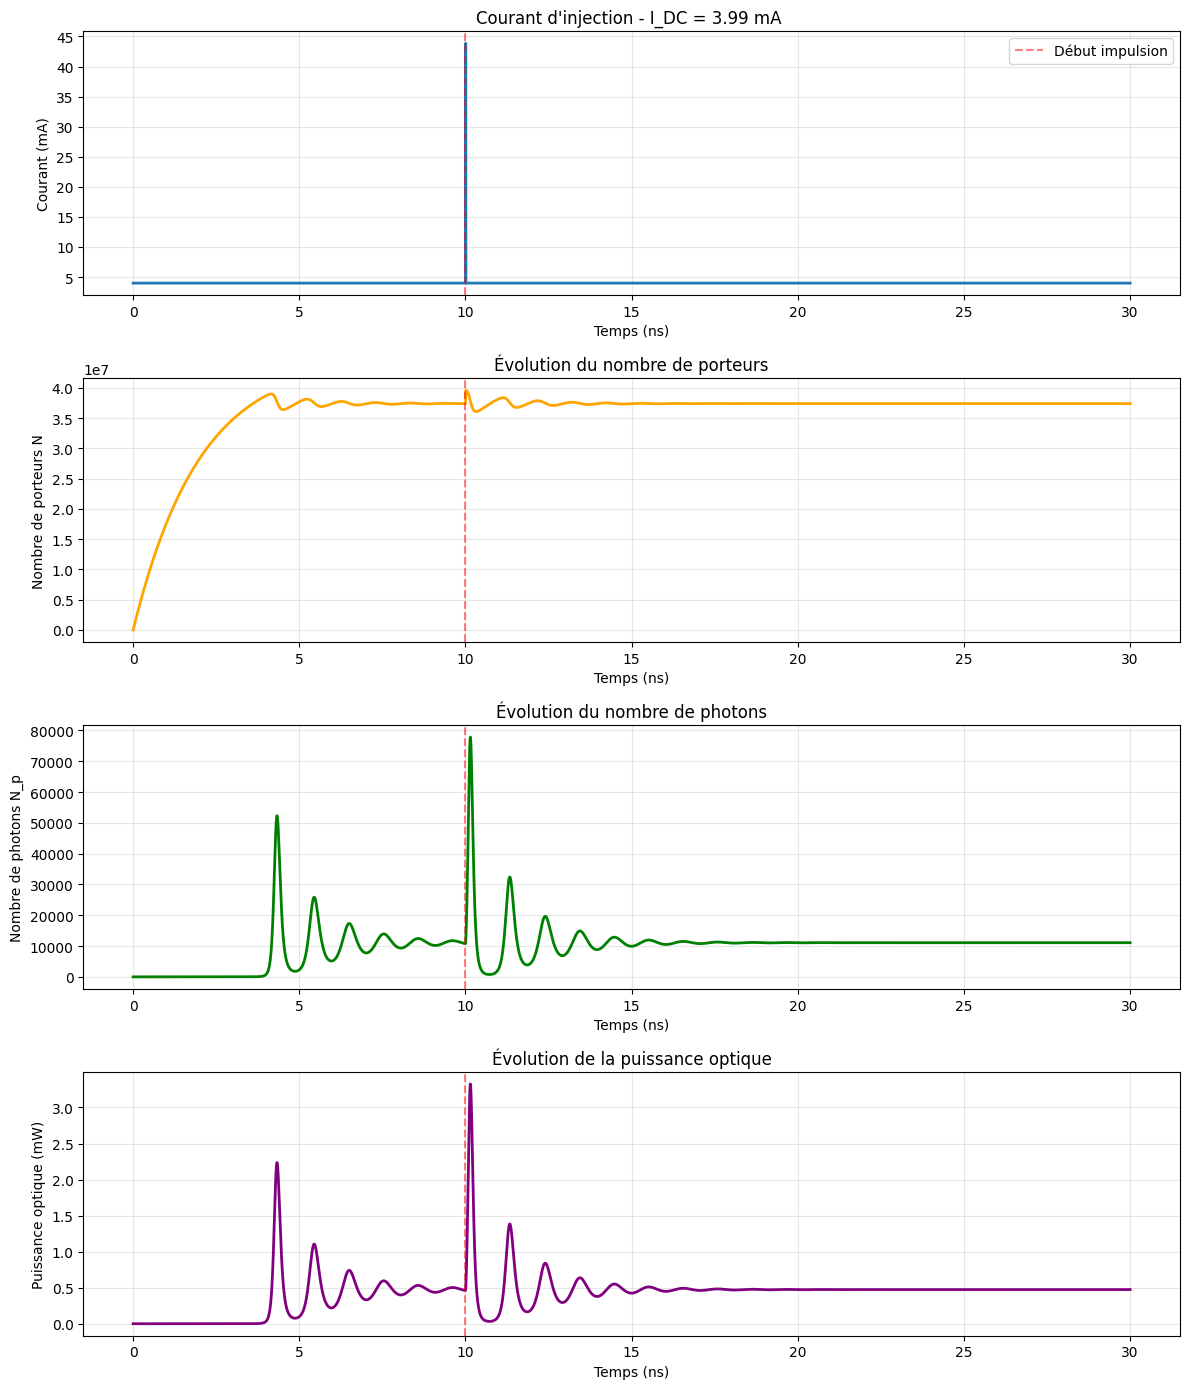

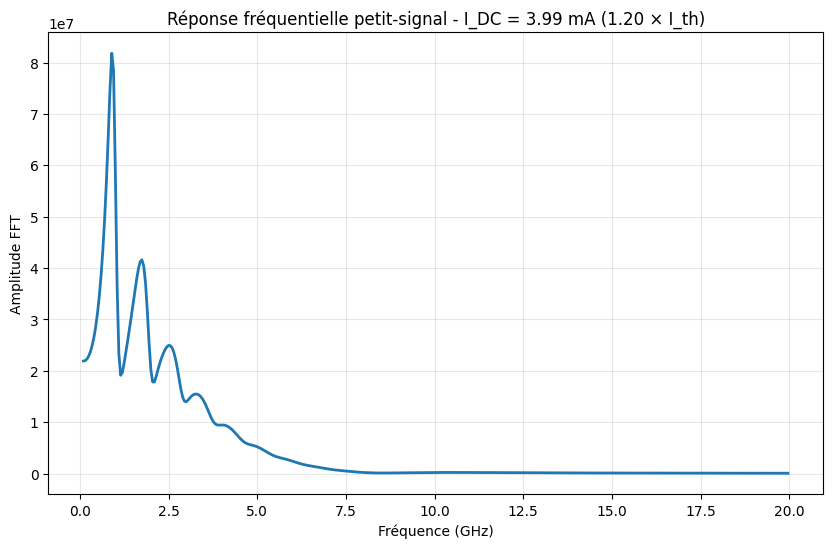

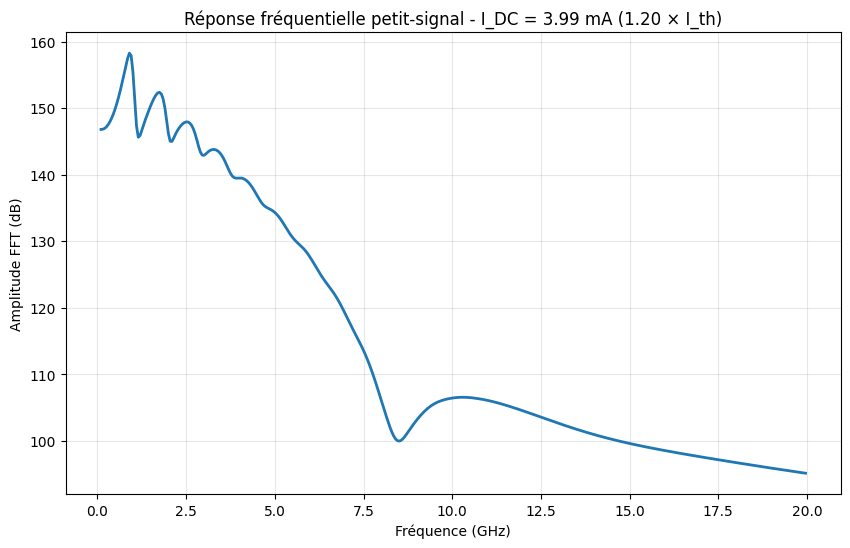

  Fréquence de résonance: 0.90 GHz

Simulation pour I_DC = 4.98 mA (1.50 × I_th)


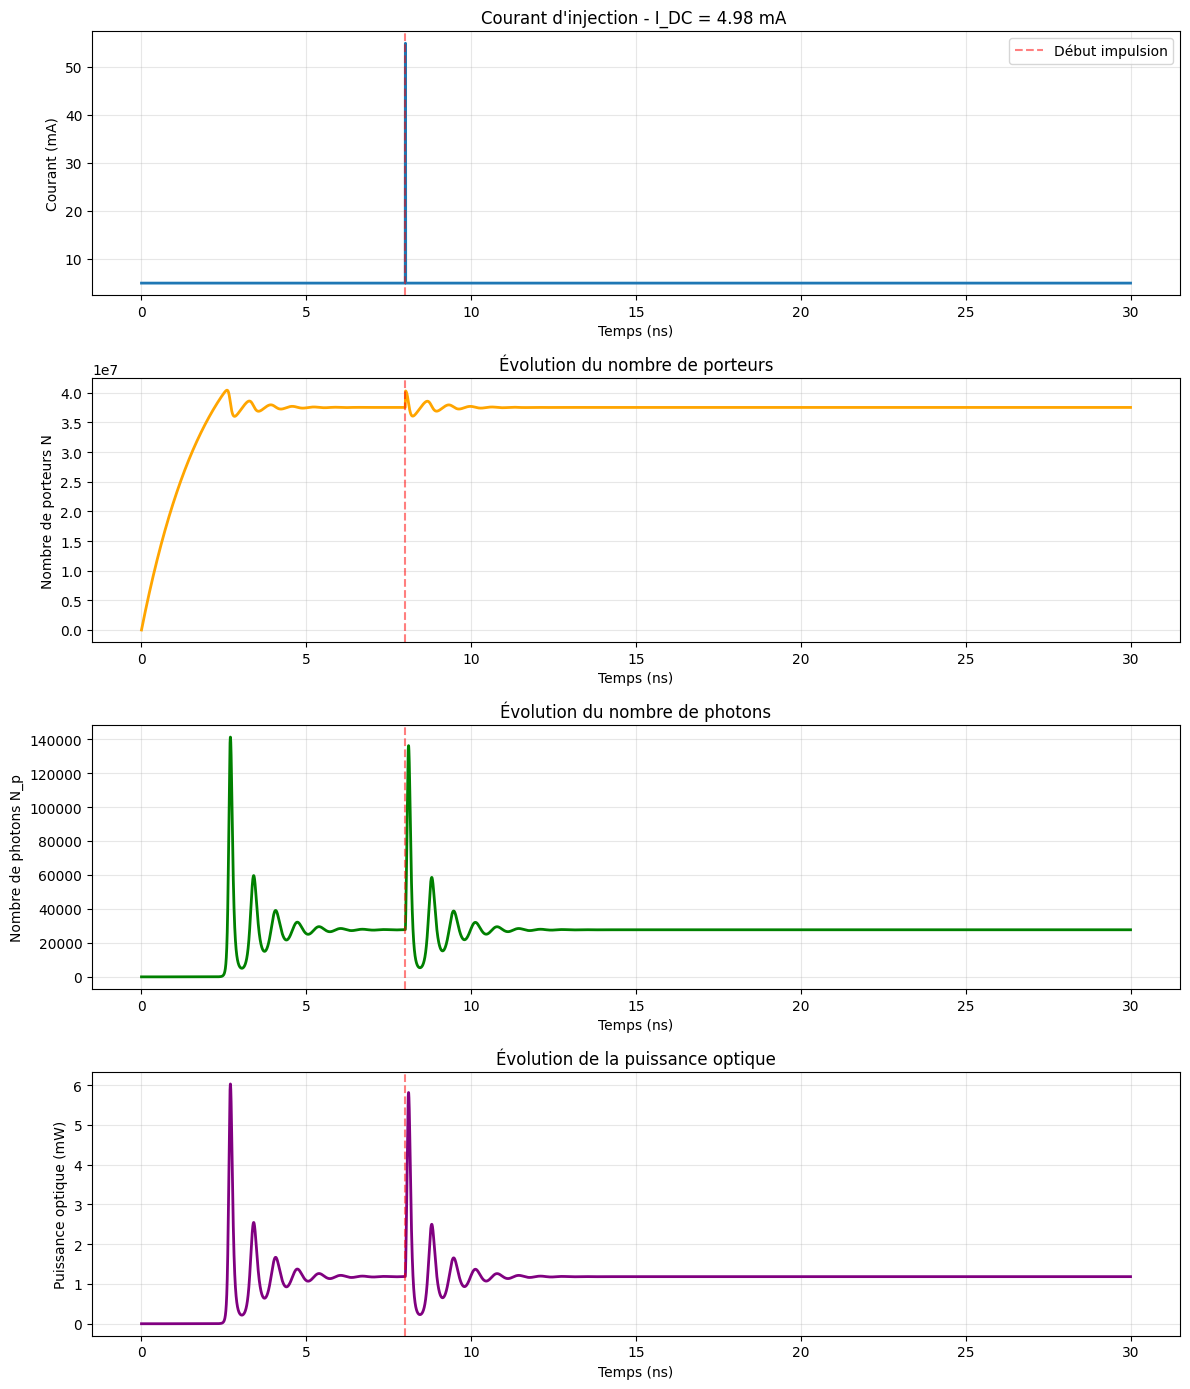

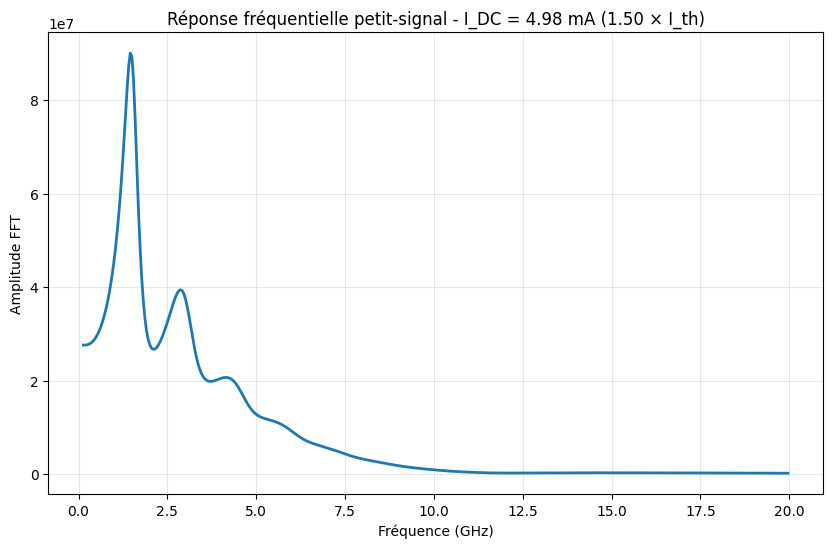

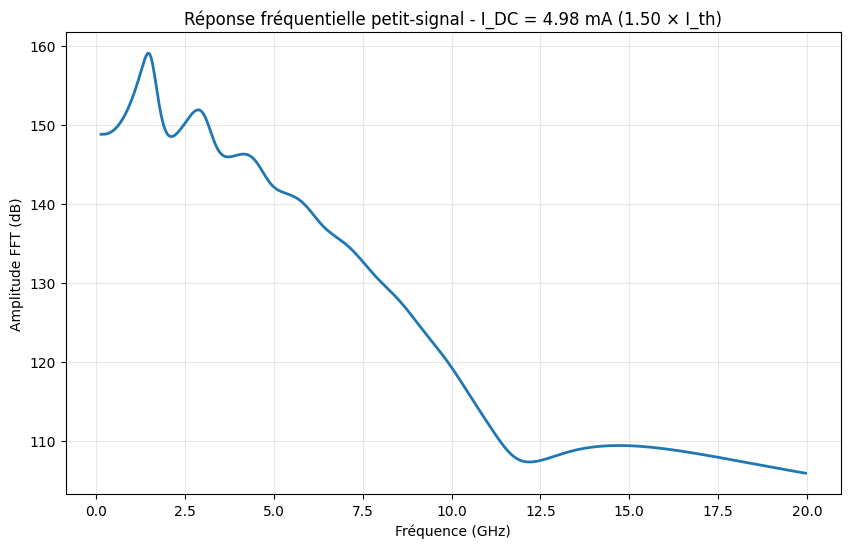

  Fréquence de résonance: 1.46 GHz

Simulation pour I_DC = 8.31 mA (2.50 × I_th)


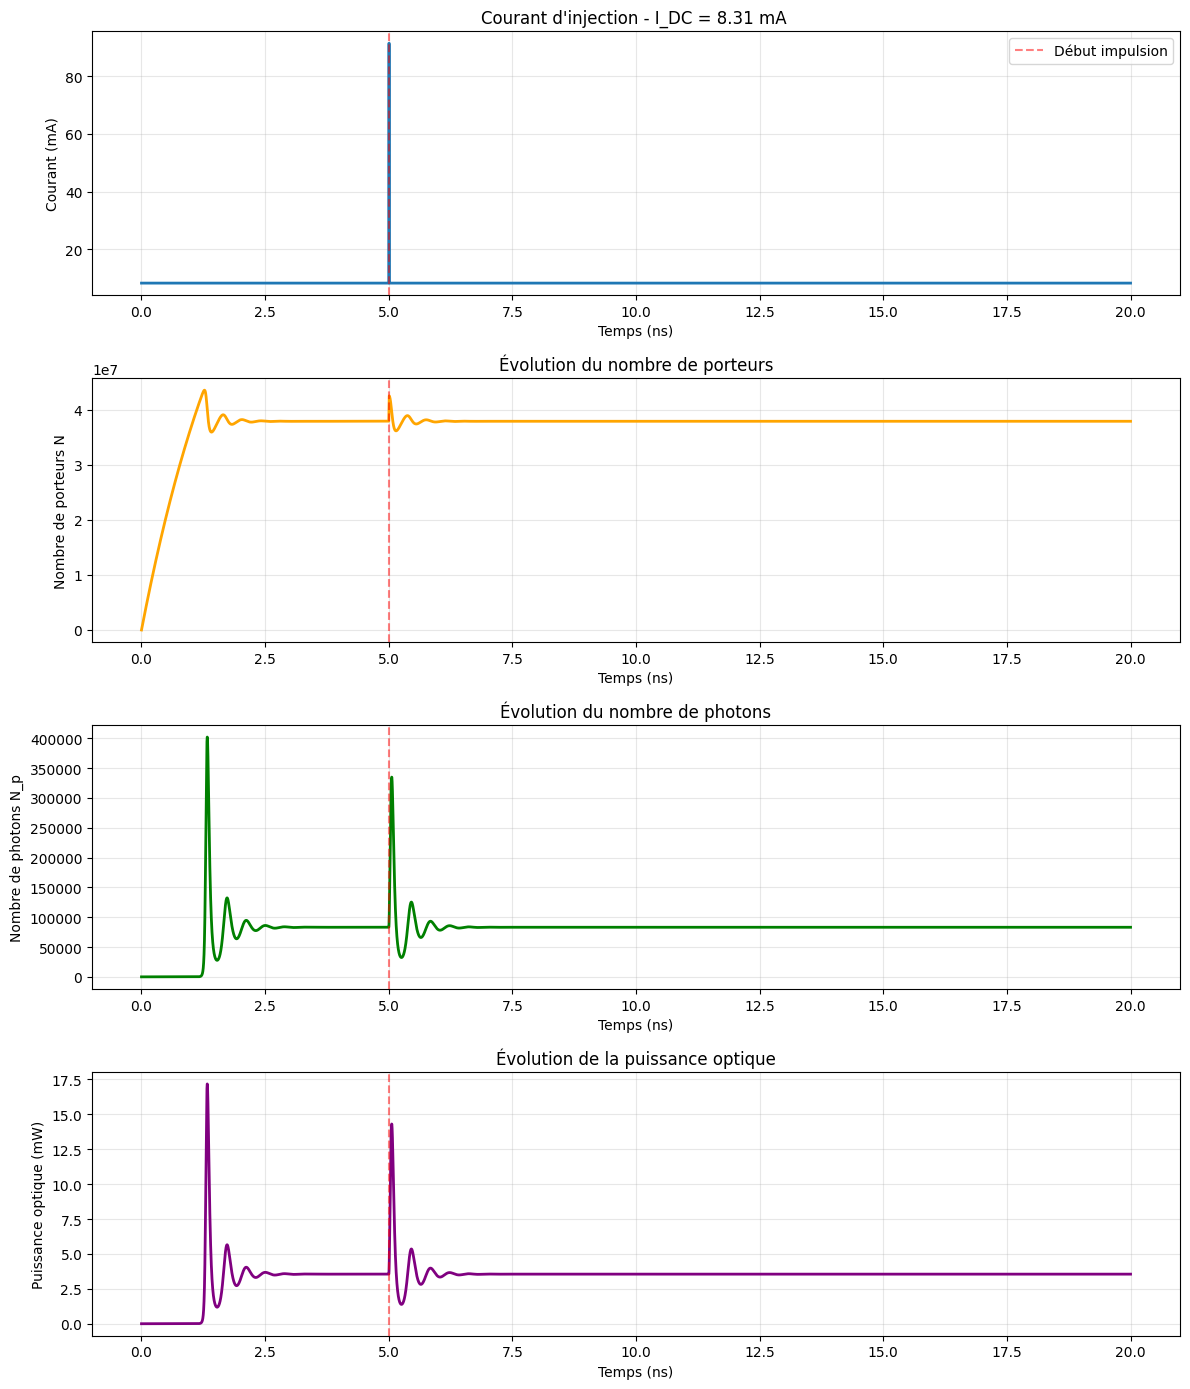

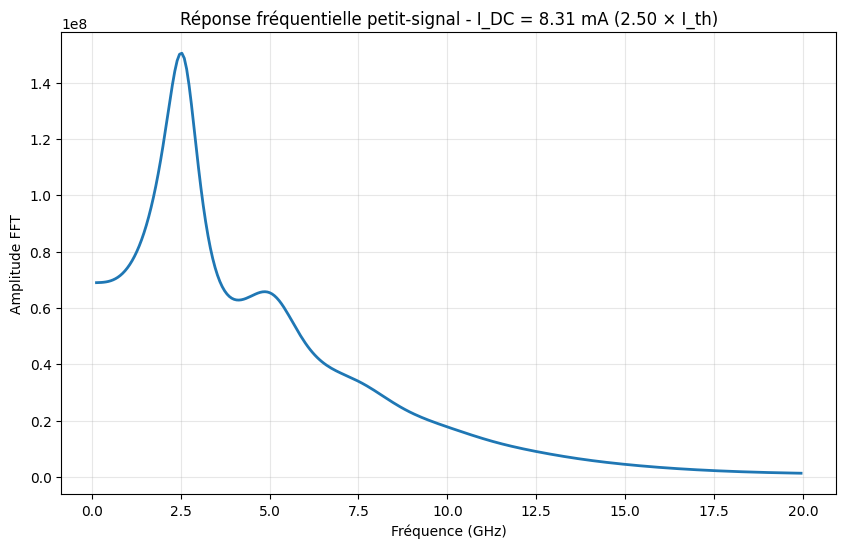

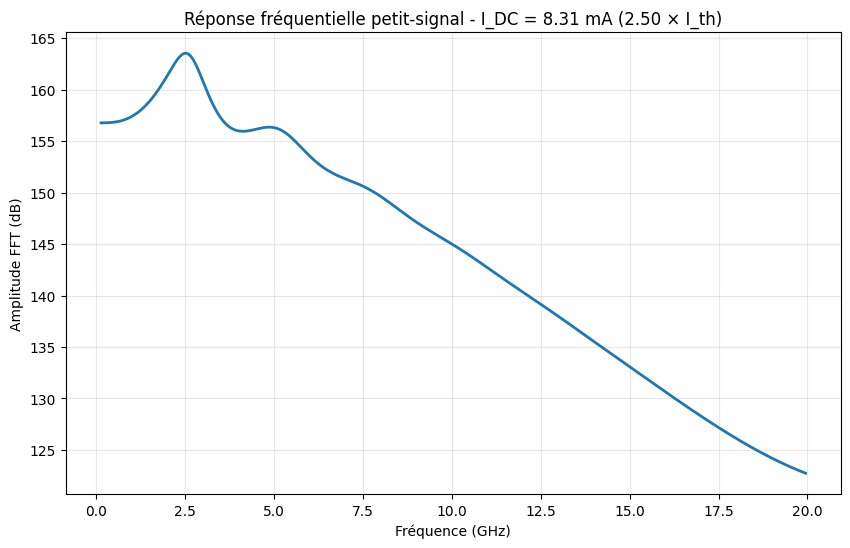

  Fréquence de résonance: 2.53 GHz

Simulation pour I_DC = 16.62 mA (5.00 × I_th)


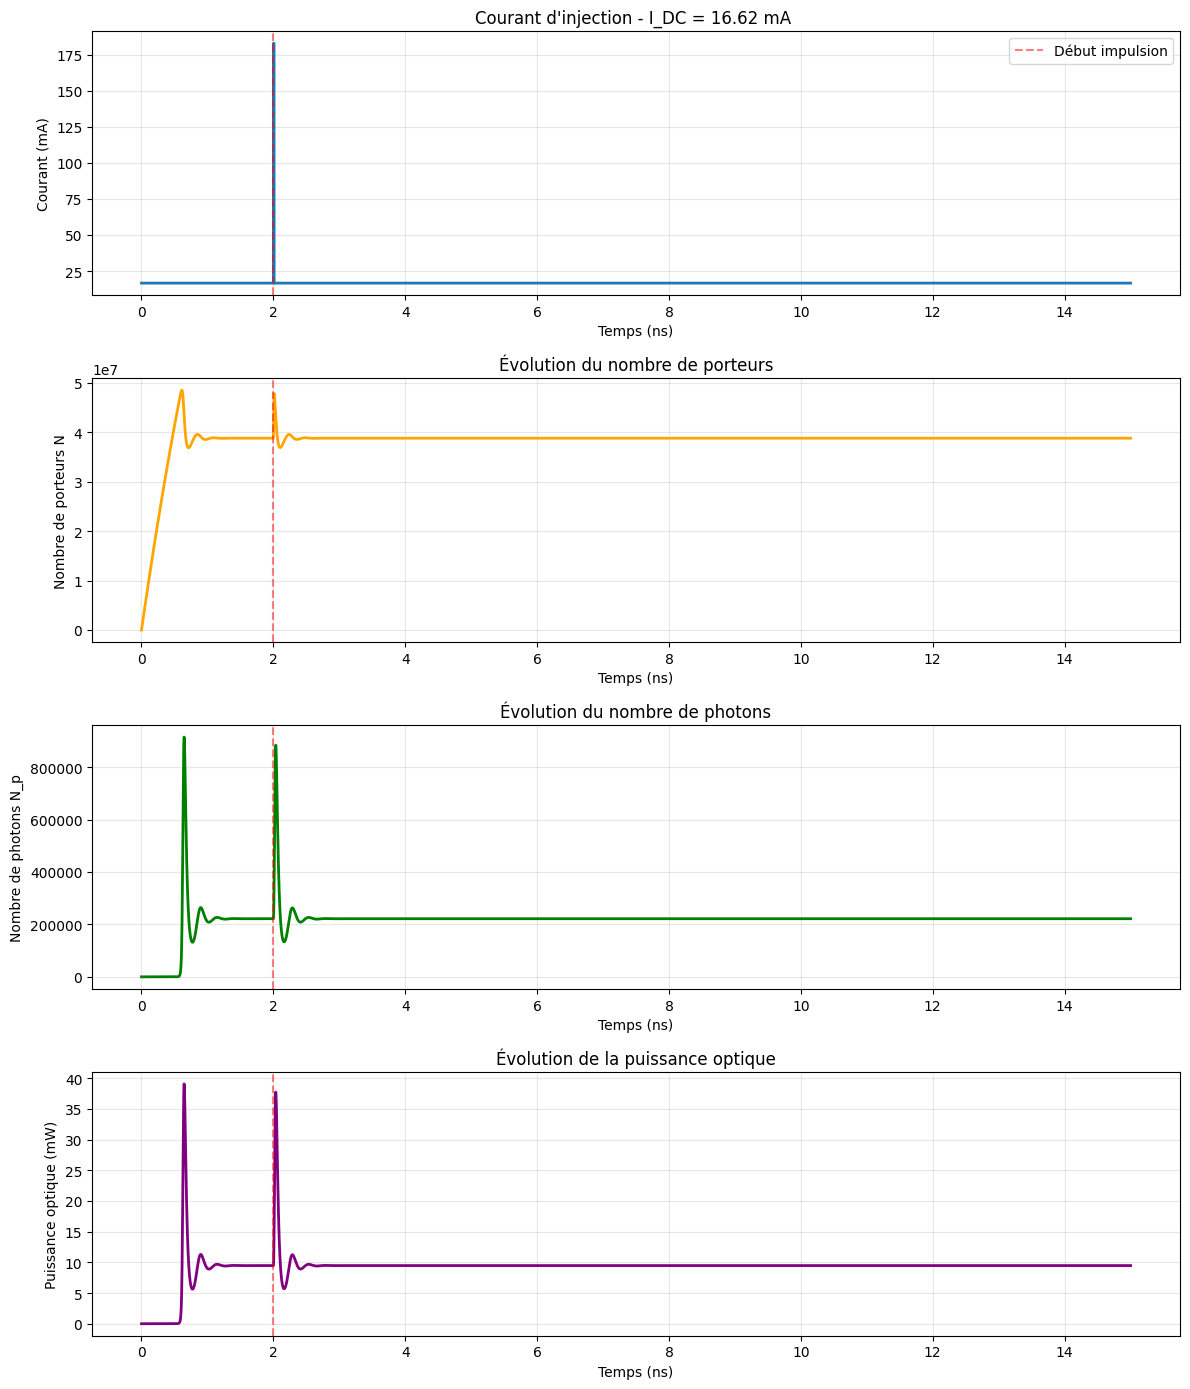

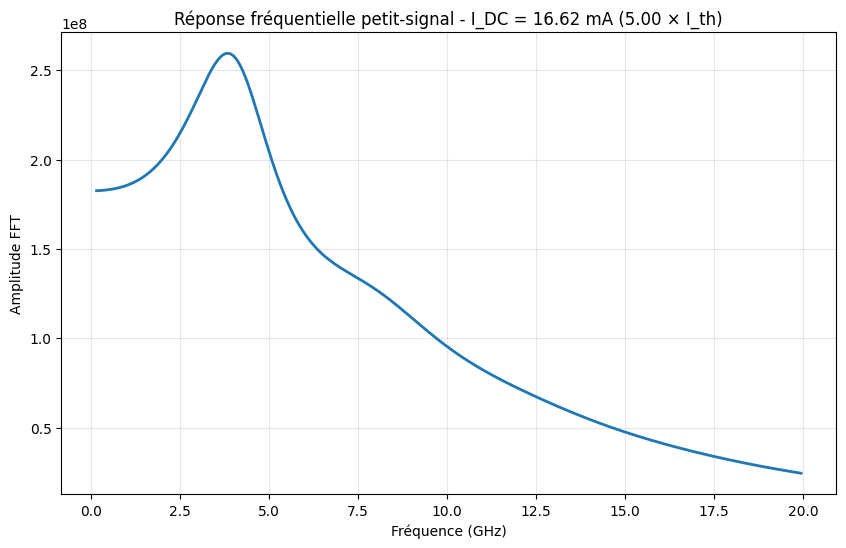

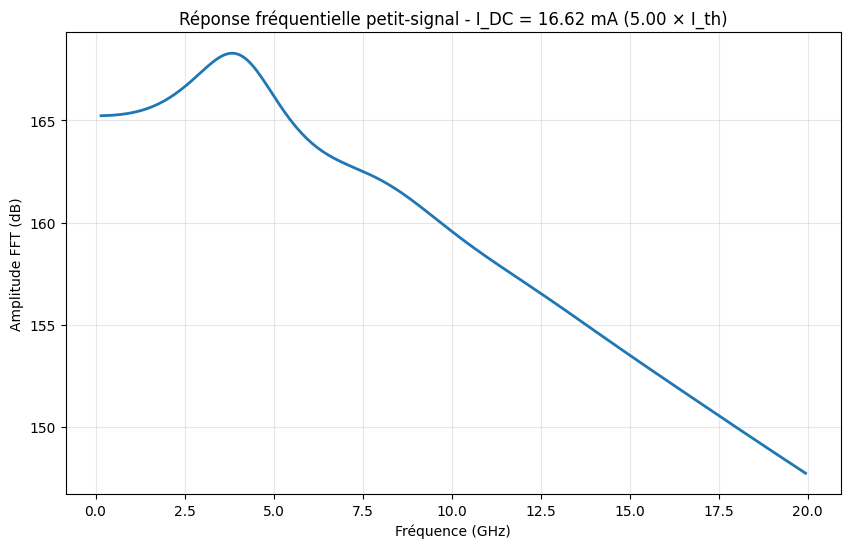

  Fréquence de résonance: 3.85 GHz

Simulation pour I_DC = 33.23 mA (10.00 × I_th)


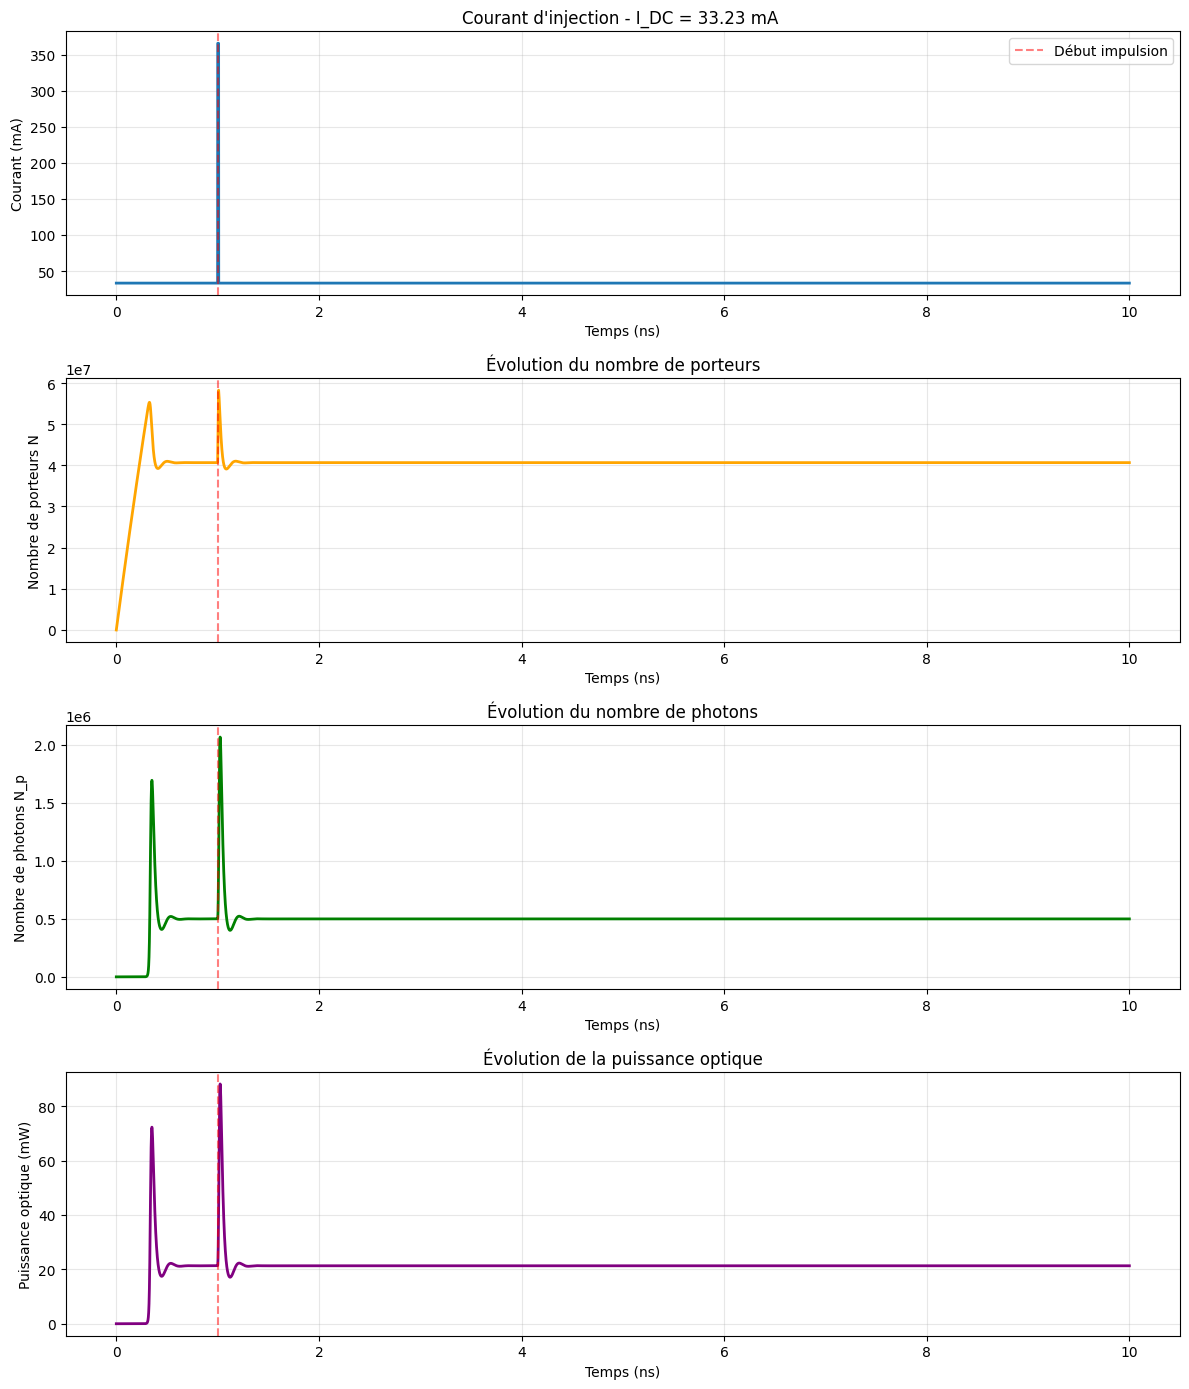

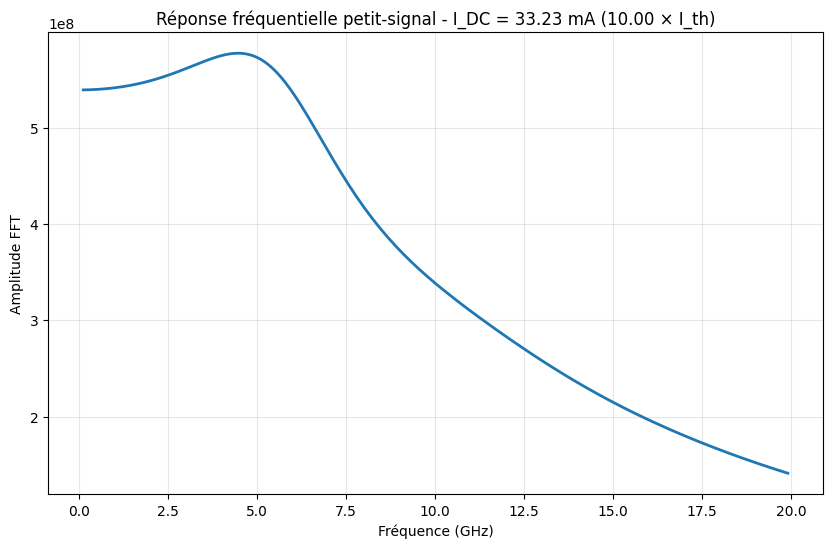

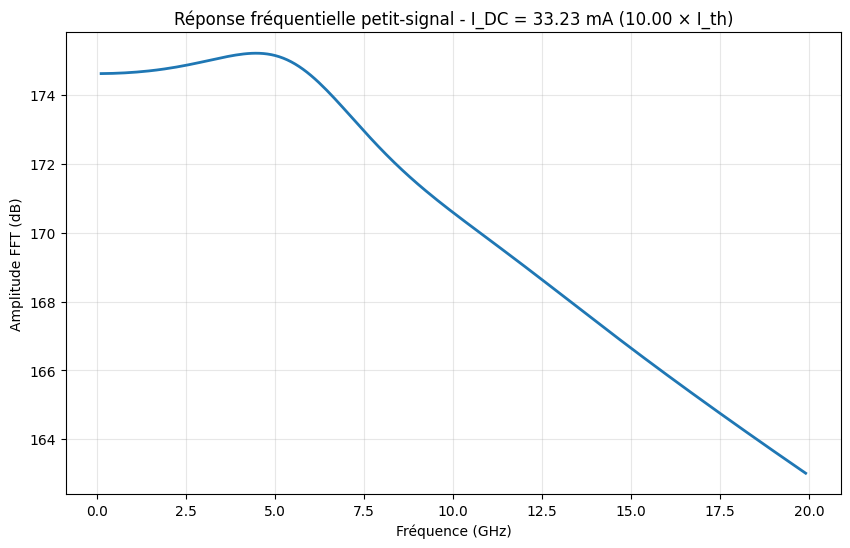

  Fréquence de résonance: 4.45 GHz

RÉSUMÉ DES FRÉQUENCES DE RÉSONANCE
I_DC = 3.99 mA (1.20 × I_th) : f_res = 0.90 GHz
I_DC = 4.98 mA (1.50 × I_th) : f_res = 1.46 GHz
I_DC = 8.31 mA (2.50 × I_th) : f_res = 2.53 GHz
I_DC = 16.62 mA (5.00 × I_th) : f_res = 3.85 GHz
I_DC = 33.23 mA (10.00 × I_th) : f_res = 4.45 GHz


In [255]:
# Définir les paramètres du laser dans un dictionnaire
laser_params = {
    'η_i': η_i,
    'τ': τ,
    'R_sp_prime': R_sp_prime,
    'G_0': G_0,
    'N_tr': N_tr,
    'ϵ': ϵ,
    'τ_p': τ_p,
    'λ_0': λ_0
}

# Définir les paramètres temporels
time_params = {  # 25 ns total
    'n_points': 100000
}

# Définir les courants DC à tester
I_DC_vector = [1.2*I_th, 1.5*I_th, 2.5*I_th, 5*I_th, 10*I_th]

# Définir les paramètres d'impulsion pour chaque courant DC
pulse_parameters = {}

pulse_parameters[I_DC_vector[0]] = {
        'total_time': 30e-9,
        'delay_impulsion': 10e-9,      
        'durée_impulsion': 10e-12,   # 100 ps de durée
        'current_impulsion': 10*I_DC_vector[0]     
    }
pulse_parameters[I_DC_vector[1]] = {
        'total_time': 30e-9,
        'delay_impulsion': 8e-9,      
        'durée_impulsion': 10e-12,   # 100 ps de durée
        'current_impulsion': 10*I_DC_vector[1]     # 10 mA d'amplitude
    }
pulse_parameters[I_DC_vector[2]] = {
        'total_time': 20e-9,
        'delay_impulsion': 5e-9,      # 5 ns de délai
        'durée_impulsion': 10e-12,   # 100 ps de durée
        'current_impulsion': 10*I_DC_vector[2]     # 10 mA d'amplitude
    }
pulse_parameters[I_DC_vector[3]] = {
        'total_time': 15e-9,
        'delay_impulsion': 2e-9,      # 5 ns de délai
        'durée_impulsion': 10e-12,   # 100 ps de durée
        'current_impulsion': 10*I_DC_vector[3]    # 10 mA d'amplitude
    }
pulse_parameters[I_DC_vector[4]] = {
        'total_time': 10e-9,
        'delay_impulsion': 1e-9,      # 5 ns de délai
        'durée_impulsion': 10e-12,   # 100 ps de durée
        'current_impulsion': 10*I_DC_vector[4]     
    }

# Dictionnaire pour stocker les résultats
results_dict = {}
fft_dict = {}
resonance_freq = {}

print("="*80)
print("SIMULATION DE LA RÉPONSE PETIT-SIGNAL POUR DIFFÉRENTS COURANTS DC")
print("="*80)

# Boucle sur tous les courants DC
for I_DC in I_DC_vector:
    print(f"\nSimulation pour I_DC = {I_DC*1e3:.2f} mA ({I_DC/I_th:.2f} × I_th)")
    
    # Simuler la réponse
    results = simulate_pulse_response(I_DC, pulse_parameters[I_DC], laser_params, time_params)
    results_dict[I_DC] = results
    
    # Tracer les résultats
    plot_simulation_results(results, I_DC)
    
    # Calculer et tracer la FFT
    fft_results = compute_fft_after_pulse(results, freq_range=(0.1e9, 20e9))
    fft_dict[I_DC] = fft_results
    
    # Tracer la FFT (linéaire)
    plot_fft_response(fft_results, I_DC, plot_type='linear')
    
    # Tracer la FFT (log)
    plot_fft_response(fft_results, I_DC, plot_type='log')
    
    # Trouver la fréquence de résonance
    f_res = find_resonance_frequency(fft_results)
    resonance_freq[I_DC] = f_res
    print(f"  Fréquence de résonance: {f_res/1e9:.2f} GHz")

print("\n" + "="*80)
print("RÉSUMÉ DES FRÉQUENCES DE RÉSONANCE")
print("="*80)
for I_DC in I_DC_vector:
    print(f"I_DC = {I_DC*1e3:.2f} mA ({I_DC/I_th:.2f} × I_th) : f_res = {resonance_freq[I_DC]/1e9:.2f} GHz")
print("="*80)

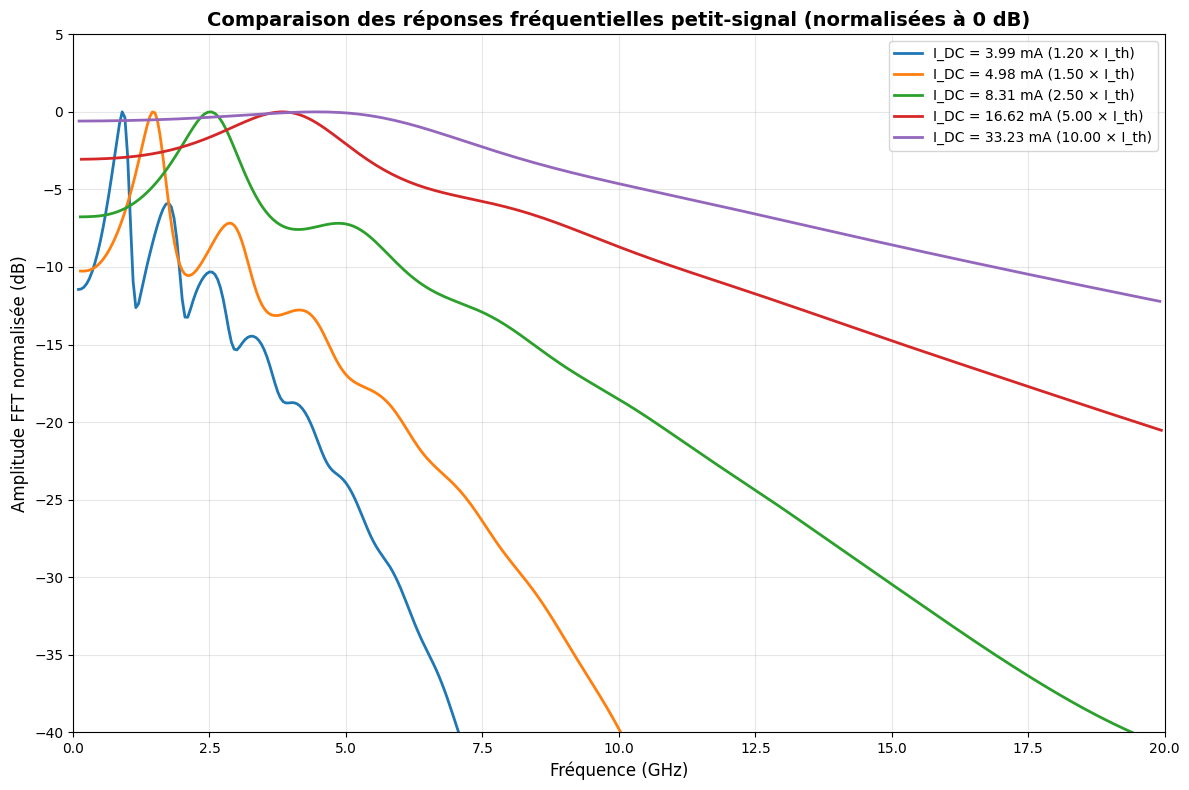

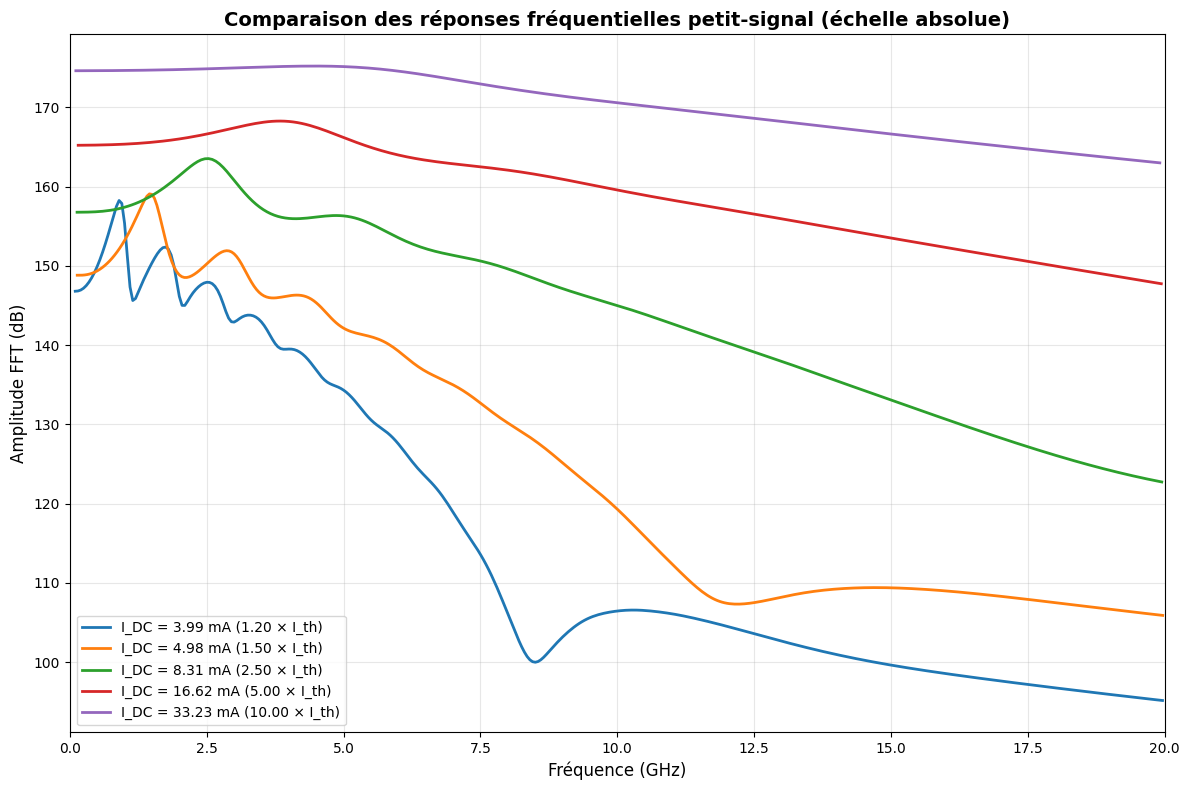

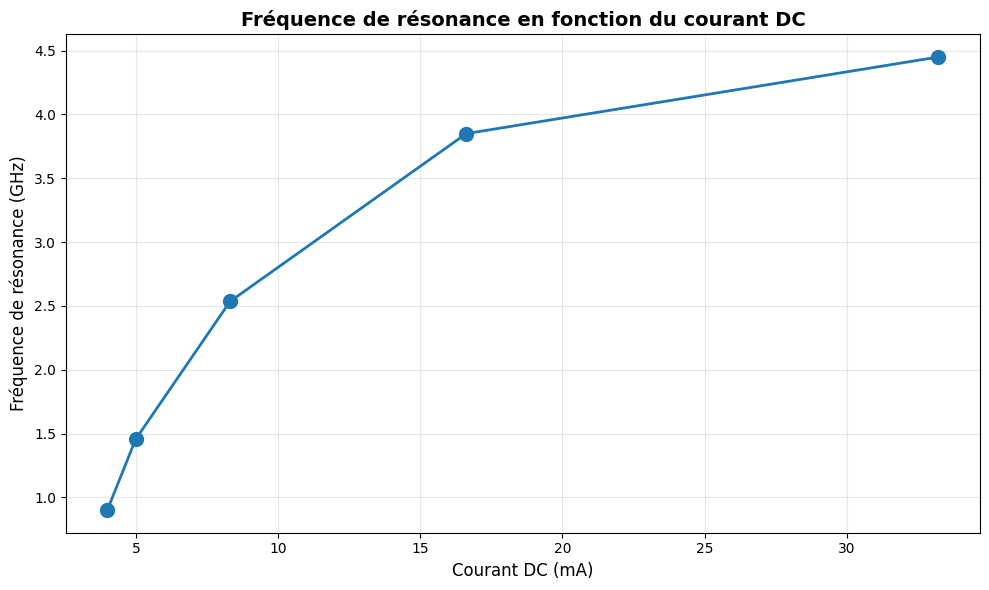

In [257]:
# Tracer toutes les réponses FFT sur un même graphique pour comparaison (NORMALISÉES à 0 dB)
plt.figure(figsize=(12, 8))

for I_DC in I_DC_vector:
    fft_results = fft_dict[I_DC]
    freq_GHz = fft_results['freq_filtered'] / 1e9
    amplitude = fft_results['amplitude_filtered']
    
    # Normaliser l'amplitude : diviser par le maximum
    amplitude_normalized = amplitude / np.max(amplitude)
    
    # Convertir en dB (maintenant le maximum sera à 0 dB)
    amplitude_dB_normalized = 20 * np.log10(amplitude_normalized + 1e-10)
    
    plt.plot(freq_GHz, amplitude_dB_normalized, linewidth=2, 
             label=f"I_DC = {I_DC*1e3:.2f} mA ({I_DC/I_th:.2f} × I_th)")

plt.xlabel("Fréquence (GHz)", fontsize=12)
plt.ylabel("Amplitude FFT normalisée (dB)", fontsize=12)
plt.title("Comparaison des réponses fréquentielles petit-signal (normalisées à 0 dB)", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(0, 20)
plt.ylim(-40, 5)  # Limiter l'axe Y pour mieux voir la forme des courbes
plt.tight_layout()
plt.show()

# Version non normalisée pour référence
plt.figure(figsize=(12, 8))

for I_DC in I_DC_vector:
    fft_results = fft_dict[I_DC]
    freq_GHz = fft_results['freq_filtered'] / 1e9
    amplitude_dB = 20 * np.log10(fft_results['amplitude_filtered'] + 1e-10)
    
    plt.plot(freq_GHz, amplitude_dB, linewidth=2, 
             label=f"I_DC = {I_DC*1e3:.2f} mA ({I_DC/I_th:.2f} × I_th)")

plt.xlabel("Fréquence (GHz)", fontsize=12)
plt.ylabel("Amplitude FFT (dB)", fontsize=12)
plt.title("Comparaison des réponses fréquentielles petit-signal (échelle absolue)", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(0, 20)
plt.tight_layout()
plt.show()

# Tracer la fréquence de résonance en fonction du courant DC
I_DC_mA = [I*1e3 for I in I_DC_vector]
f_res_GHz = [resonance_freq[I]/1e9 for I in I_DC_vector]

plt.figure(figsize=(10, 6))
plt.plot(I_DC_mA, f_res_GHz, 'o-', linewidth=2, markersize=10)
plt.xlabel("Courant DC (mA)", fontsize=12)
plt.ylabel("Fréquence de résonance (GHz)", fontsize=12)
plt.title("Fréquence de résonance en fonction du courant DC", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

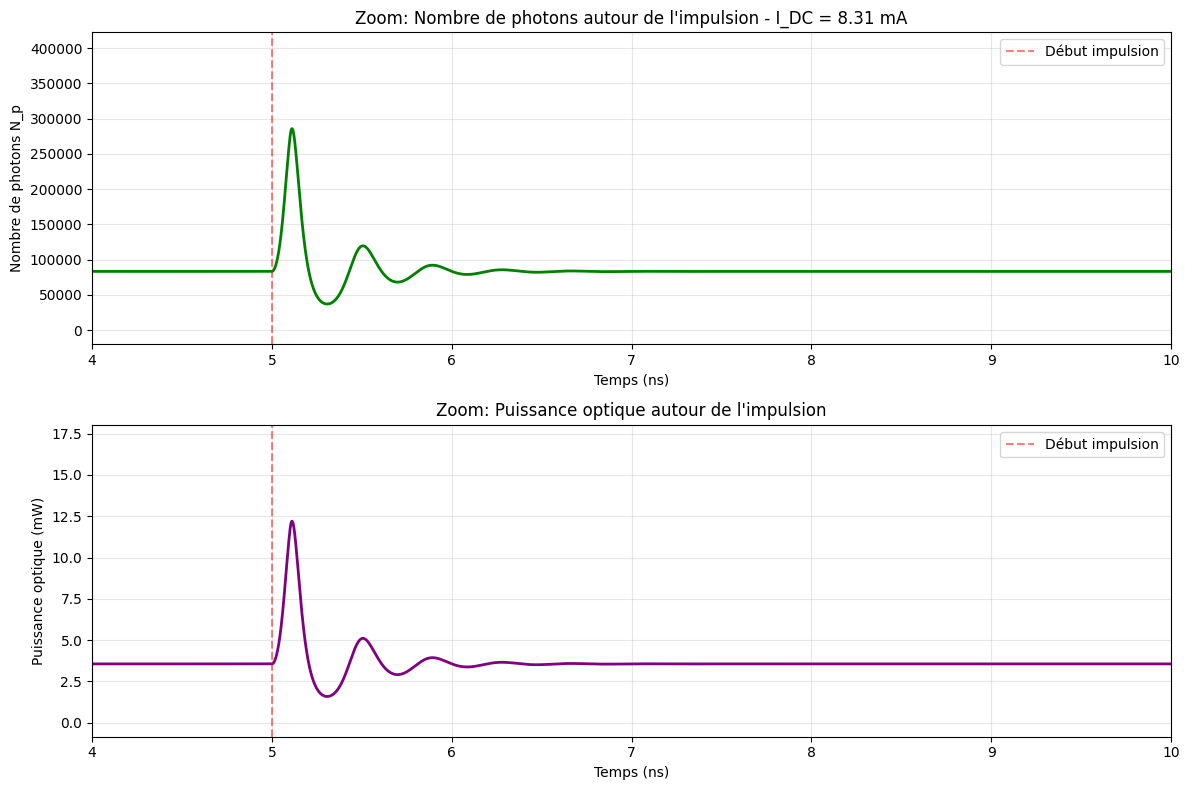

In [246]:
# Zoom autour de l'impulsion pour un courant DC spécifique
I_DC_zoom = 2.5 * I_th  # Choisir un courant pour le zoom

results_zoom = results_dict[I_DC_zoom]
time_ns = results_zoom['time'] * 1e9
delay_ns = results_zoom['pulse_start'] * 1e9

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Subplot 1: Nombre de photons
ax1.plot(time_ns, results_zoom['N_p'], linewidth=2, color='green')
ax1.axvline(delay_ns, color='red', linestyle='--', alpha=0.5, label='Début impulsion')
ax1.set_xlim((delay_ns - 1), (delay_ns + 5))
ax1.set_xlabel("Temps (ns)")
ax1.set_ylabel("Nombre de photons N_p")
ax1.set_title(f"Zoom: Nombre de photons autour de l'impulsion - I_DC = {I_DC_zoom*1e3:.2f} mA")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2: Puissance
ax2.plot(time_ns, results_zoom['P_out']*1e3, linewidth=2, color='purple')
ax2.axvline(delay_ns, color='red', linestyle='--', alpha=0.5, label='Début impulsion')
ax2.set_xlim((delay_ns - 1), (delay_ns + 5))
ax2.set_xlabel("Temps (ns)")
ax2.set_ylabel("Puissance optique (mW)")
ax2.set_title("Zoom: Puissance optique autour de l'impulsion")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

### Observations et comparaison avec la réponse d'ouverture

La réponse fréquentielle petit-signal obtenue par FFT de la réponse à une impulsion nous donne la fonction de transfert **S₂₁** du laser. Cette analyse révèle plusieurs caractéristiques importantes :

#### Fréquence de résonance
- La fréquence de résonance augmente avec le courant DC
- Cette fréquence correspond aux oscillations de relaxation observées lors de l'ouverture du laser (question 4.F)
- Plus le courant est élevé, plus la réponse est rapide et la fréquence de résonance est élevée

#### Comparaison avec la réponse d'ouverture
On observe que :
1. Les fréquences d'oscillation mesurées lors de l'ouverture (4.F) correspondent aux fréquences de résonance de la réponse petit-signal
2. L'amortissement des oscillations dans la réponse temporelle se traduit par la largeur de la résonance dans le domaine fréquentiel
3. La réponse petit-signal nous donne directement la bande passante de modulation du laser

#### Implications pratiques
- La bande passante de modulation augmente avec le courant de polarisation
- Pour des applications de télécommunications, il est avantageux d'opérer à des courants élevés (mais attention à l'échauffement)
- La résonance observée limite la bande passante utilisable du laser